In [20]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import dot, multiply, diag, power
from numpy import pi, exp, sin, cos
from numpy.linalg import inv, eig, pinv, solve
from scipy.linalg import svd, svdvals
from math import floor, ceil # python 3.x

import scipy.io

import matplotlib.pyplot as plt
import numpy as np
import scipy
import math

from sklearn.metrics import mean_squared_error
#from pydmd.plotter import plot_eigs

import matplotlib

import numpy as np
import matplotlib.pyplot as plt
from numpy import dot, multiply, diag, power
from numpy import pi, exp, sin, cos
from numpy.linalg import inv, eig, pinv, solve
from scipy.linalg import svd, svdvals
from math import floor, ceil # python 3.x

import scipy.io

#from pydmd import dmdc


"""
Derived module from dmdbase.py for dmd with control.

Reference:
- Proctor, J.L., Brunton, S.L. and Kutz, J.N., 2016. Dynamic mode decomposition
with control. SIAM Journal on Applied Dynamical Systems, 15(1), pp.142-161.
"""
import numpy as np

from pydmd.dmdbase import DMDBase
from pydmd.dmdoperator import DMDOperator
from pydmd.snapshots import Snapshots
from pydmd.utils import compute_svd, compute_tlsq
from pydmd.plotter import plot_eigs_mrdmd


import control as ct
from scipy import signal

import harold


class DMDControlOperator(DMDOperator):
    """
    DMD with control base operator. This should be subclassed in order to
    implement the appropriate features.

    :param svd_rank: the rank for the truncation; If 0, the method computes the
        optimal rank and uses it for truncation; if positive interger, the
        method uses the argument for the truncation; if float between 0 and 1,
        the rank is the number of the biggest singular values that are needed
        to reach the 'energy' specified by `svd_rank`; if -1, the method does
        not compute truncation.
    :type svd_rank: int or float
    :param svd_rank_omega: the rank for the truncation of the aumented matrix
        omega composed by the left snapshots matrix and the control. Used only
        for the `_fit_B_unknown` method of this class. It should be greater or
        equal than `svd_rank`. For the possible values please refer to the
        `svd_rank` parameter description above.
    :type svd_rank_omega: int or float
    :param int tlsq_rank: rank truncation computing Total Least Square. Default
        is 0, that means no truncation.
    """

    def __init__(self, svd_rank, svd_rank_omega, tlsq_rank):
        super(DMDControlOperator, self).__init__(
            svd_rank=svd_rank,
            exact=True,
            rescale_mode=None,
            forward_backward=False,
            sorted_eigs=False,
            tikhonov_regularization=None,
        )
        self._svd_rank_omega = svd_rank_omega
        self._tlsq_rank = tlsq_rank


class DMDBKnownOperator(DMDControlOperator):
    """
    DMD with control base operator when B is given.

    :param svd_rank: the rank for the truncation; If 0, the method computes the
        optimal rank and uses it for truncation; if positive interger, the
        method uses the argument for the truncation; if float between 0 and 1,
        the rank is the number of the biggest singular values that are needed
        to reach the 'energy' specified by `svd_rank`; if -1, the method does
        not compute truncation.
    :type svd_rank: int or float
    :param svd_rank_omega: the rank for the truncation of the aumented matrix
        omega composed by the left snapshots matrix and the control. Used only
        for the `_fit_B_unknown` method of this class. It should be greater or
        equal than `svd_rank`. For the possible values please refer to the
        `svd_rank` parameter description above.
    :type svd_rank_omega: int or float
    :param int tlsq_rank: rank truncation computing Total Least Square. Default
        is 0, that means no truncation.
    """

    def compute_operator(self, X, Y, B, controlin):
        """
        Compute the low-rank operator. This is the standard version of the DMD
        operator, with a correction which depends on B.

        :param numpy.ndarray X: matrix containing the snapshots x0,..x{n-1} by
            column.
        :param numpy.ndarray Y: matrix containing the snapshots x1,..x{n} by
            column.
        :param numpy.ndarray B: the matrix B.
        :param numpy.ndarray control: the control input.
        :return: the (truncated) left-singular vectors matrix, the (truncated)
            singular values array, the (truncated) right-singular vectors
            matrix of X.
        :rtype: numpy.ndarray, numpy.ndarray, numpy.ndarray
        """
        X, Y = compute_tlsq(X, Y, self._tlsq_rank)
        Y = Y - B.dot(controlin)
        return super(DMDBKnownOperator, self).compute_operator(X, Y)


class DMDBUnknownOperator(DMDControlOperator):
    """
    DMD with control base operator when B is unknown.

    :param svd_rank: the rank for the truncation; If 0, the method computes the
        optimal rank and uses it for truncation; if positive interger, the
        method uses the argument for the truncation; if float between 0 and 1,
        the rank is the number of the biggest singular values that are needed
        to reach the 'energy' specified by `svd_rank`; if -1, the method does
        not compute truncation.
    :type svd_rank: int or float
    :param svd_rank_omega: the rank for the truncation of the aumented matrix
        omega composed by the left snapshots matrix and the control. Used only
        for the `_fit_B_unknown` method of this class. It should be greater or
        equal than `svd_rank`. For the possible values please refer to the
        `svd_rank` parameter description above.
    :type svd_rank_omega: int or float
    :param int tlsq_rank: rank truncation computing Total Least Square. Default
        is 0, that means no truncation.
    """

    def max_value(matrix):
        max_value = np.max([np.max(matrix)])
        min_value = np.min([np.max(matrix)])
        if (max_value >= -(min_value)):
            scale = max_value
        else:
            scale = -min_value
        return scale


    def compute_operator(self, X, Y, controlin):
        """
        Compute the low-rank operator.

        :param numpy.ndarray X: matrix containing the snapshots x0,..x{n-1} by
            column.
        :param numpy.ndarray Y: matrix containing the snapshots x1,..x{n} by
            column.
        :param numpy.ndarray control: the control input.
        :return: the (truncated) left-singular vectors matrix of Y, and
            the product between the left-singular vectors of Y and Btilde.
        :rtype: numpy.ndarray, numpy.ndarray
        """
        snapshots_rows = X.shape[0]

        omega = np.vstack([X, controlin])

        Up, sp, Vp = compute_svd(omega, self._svd_rank_omega)

        Up1 = Up[:snapshots_rows, :]
        Up2 = Up[snapshots_rows:, :]

        Ur, _, _ = compute_svd(Y, self._svd_rank)

        self._Atilde = np.linalg.multi_dot(
            [Ur.T.conj(), Y, Vp, np.diag(np.reciprocal(sp)), Up1.T.conj(), Ur]
        )

        #GABRIELE non viene utilizzata, serve solo per dimostrare che la A in reconstructed_data è fatta così 
        _A = np.linalg.multi_dot(
            [Ur, Ur.T.conj(), Y, Vp, np.diag(np.reciprocal(sp)), Up1.T.conj()]
        )

        x = np.linspace(0, self._Atilde.shape[0], self._Atilde.shape[0])
        y = np.linspace(0, self._Atilde.shape[1], self._Atilde.shape[1])
        max_value = np.max([np.max(self._Atilde)])
        min_value = np.min([np.min(self._Atilde)])
        if (max_value >= -(min_value)):
            scale = max_value
        else:
            scale = -min_value
        
        #make_plot(self._Atilde, x=y, y=x, title = '_Atilde ', xlabel = 'Input', ylabel = 'Output', vmin = -(scale), vmax = scale) 
            
        x = np.linspace(0, _A.shape[0], _A.shape[0])
        y = np.linspace(0, _A.shape[1], _A.shape[1])
        max_value = np.max([np.max(_A)])
        min_value = np.min([np.min(_A)])
        if (max_value >= -(min_value)):
            scale = max_value
        else:
            scale = -min_value
        
        #make_plot(_A, x=y, y=x, title = '_A ', xlabel = 'Input', ylabel = 'Output', vmin = -(scale), vmax = scale) 



        self._compute_eigenquantities()
        self._compute_modes(Y, sp, Vp, Up1, Ur)

        Btilde = np.linalg.multi_dot(
            [Ur.T.conj(), Y, Vp, np.diag(np.reciprocal(sp)), Up2.T.conj()]
        )

        return Ur, Ur.dot(Btilde)

    def _compute_modes(self, Y, sp, Vp, Up1, Ur):
        """
        Private method that computes eigenvalues and eigenvectors of the
        high-dimensional operator (stored in self.modes and self.Lambda).
        """

        self._modes = np.linalg.multi_dot(
            [
                Y,
                Vp,
                np.diag(np.reciprocal(sp)),
                Up1.T.conj(),
                Ur,
                self.eigenvectors,
            ]
        )
        self._Lambda = self.eigenvalues


class DMDc(DMDBase):
    """
    Dynamic Mode Decomposition with control.
    This version does not allow to manipulate the temporal window within the
    system is reconstructed.

    :param svd_rank: the rank for the truncation; If 0, the method computes the
        optimal rank and uses it for truncation; if positive interger, the
        method uses the argument for the truncation; if float between 0 and 1,
        the rank is the number of the biggest singular values that are needed
        to reach the 'energy' specified by `svd_rank`; if -1, the method does
        not compute truncation.
    :type svd_rank: int or float
    :param int tlsq_rank: rank truncation computing Total Least Square. Default
        is 0, that means no truncation.
    :param opt: argument to control the computation of DMD modes amplitudes.
        See :class:`DMDBase`. Default is False.
    :type opt: bool or int
    :param svd_rank_omega: the rank for the truncation of the aumented matrix
        omega composed by the left snapshots matrix and the control. Used only
        for the `_fit_B_unknown` method of this class. It should be greater or
        equal than `svd_rank`. For the possible values please refer to the
        `svd_rank` parameter description above.
    :type svd_rank_omega: int or float
    """

    def __init__(self, svd_rank=0, tlsq_rank=0, opt=False, svd_rank_omega=-1):
        # we're going to initialize Atilde when we know if B is known
        self._Atilde = None
        # remember the arguments for when we'll need them
        self._dmd_operator_kwargs = {
            "svd_rank": svd_rank,
            "svd_rank_omega": svd_rank_omega,
            "tlsq_rank": tlsq_rank,
        }

        self._opt = opt
        self._exact = False

        self._B = None
        self._snapshots_holder = None
        self._controlin = None
        self._basis = None

        self._modes_activation_bitmask_proxy = None

        self.level = None            # level of recursion
        self.bin_num = None        # time bin number
        self.bin_size = None      # time bin size
        self.start = None          # starting index
        self.stop = None # stopping index
        self.step = None              # step size
        self.dato = None
        self.nyq = None
        self.rho = None

        self.A = None

        self.mu_SLOW_step = None
        self.phi_SLOW_step = None

        self.sys_cont = None
        self.mu_SLOW_cont = None

        self.sys_disc_1 = None
        self.D_dmdc_A_disc_1 = None
        self.D_dmdc_B_disc_1 = None
        self.mu_SLOW_1 = None

        self.percentage_of_filtration = None





    @property
    def svd_rank_omega(self):
        return self.operator._svd_rank_omega

    @property
    def B(self):
        """
        Get the operator B.

        :return: the operator B.
        :rtype: numpy.ndarray
        """
        return self._B

    @property
    def basis(self):
        """
        Get the basis used to reduce the linear operator to the low dimensional
        space.

        :return: the matrix which columns are the basis vectors.
        :rtype: numpy.ndarray
        """
        return self._basis


    def max_value(matrix):
        max_value = np.max([np.max(matrix)])
        min_value = np.min([np.max(matrix)])
        if (max_value >= -(min_value)):
            scale = max_value
        else:
            scale = -min_value
        return scale



    '''GABRIELE aggiunti parametri eigs e modes per override dopo la filtrazione degli SLOW'''

    '''
    def reconstructed_data(self, control_input=None, eigs = None, modes = None, _B = None):
        """
        Return the reconstructed data, computed using the `control_input`
        argument. If the `control_input` is not passed, the original input (in
        the `fit` method) is used. The input dimension has to be consistent
        with the dynamics.

        :param numpy.ndarray control_input: the input control matrix.
        :return: the matrix that contains the reconstructed snapshots.
        :rtype: numpy.ndarray
        """
        controlin = (
            np.asarray(control_input)
            if control_input is not None
            else self._controlin
        )

        if controlin.shape[-1] != self.dynamics.shape[-1] - 1:                  #controlin 200x8
            raise RuntimeError(
                "The number of control inputs and the number of snapshots to "
                "reconstruct has to be the same"
            )
                                                                                #bin_size / step
        
        #GABRIELE imposizione degli autovalori dopo filtrazione di SLOW
        if eigs is None:
            eigs = np.power(                                                         #eigs vettore di dimensione 8 per livello 0
                self.eigs, self.dmd_time["dt"] // self.original_time["dt"]
            )

        #GABRIELE imposizione degI modes dopo filtrazione di SLOW
        if modes is None:
            modes = self.modes

        if _B is None:
            _B = self._B
        
        A = np.linalg.multi_dot(                                                  #A è una matrice 40x40 per livello 0
            [modes, np.diag(eigs), np.linalg.pinv(modes)]    
        )

        A = A.real
        self.A = A

        x = np.linspace(0, A.shape[0], A.shape[0])
        y = np.linspace(0, A.shape[1], A.shape[1])
        
        max_value = np.max([np.max(A)])
        min_value = np.min([np.min(A)])
        if (max_value >= -(min_value)):
            scale = max_value
        else:
            scale = -min_value
        
        
        #make_plot(A.real, x=y, y=x, title = 'A ' + str(self.level), xlabel = 'Input', ylabel = 'Output', vmin = -(scale), vmax = scale)

        data = [self.snapshots[:, 0]]
        expected_shape = data[0].shape


        #result = dot(self.dynamics,modes) + _B.dot(self._controlin)


        #data[i] rappresenta l'istante i-esimo dei dati dello stato
        #u rappresenta l'istante i-esimo dei dati di input
        for i, u in enumerate(controlin.T):
            arr = A.dot(data[i]) + _B.dot(u)
            if arr.shape != expected_shape:
                raise ValueError(
                    f"Invalid shape: expected {expected_shape}, got {arr.shape}"
                )
            data.append(arr)

        data = np.array(data).T

        return data
        '''




    def reconstructed_data(self, control_input=None):
        """
        Return the reconstructed data, computed using the `control_input`
        argument. If the `control_input` is not passed, the original input (in
        the `fit` method) is used. The input dimension has to be consistent
        with the dynamics.

        :param numpy.ndarray control_input: the input control matrix.
        :return: the matrix that contains the reconstructed snapshots.
        :rtype: numpy.ndarray
        """
        controlin = (
            np.asarray(control_input)
            if control_input is not None
            else self._controlin
        )

        if controlin.shape[-1] != self.dynamics.shape[-1] - 1:
            raise RuntimeError(
                "The number of control inputs and the number of snapshots to "
                "reconstruct has to be the same"
            )

        eigs = np.power(
            self.eigs, self.dmd_time["dt"] // self.original_time["dt"]
        )
        A = np.linalg.multi_dot(
            [self.modes, np.diag(eigs), np.linalg.pinv(self.modes)]    
        )

        data = [self.snapshots[:, 0]]
        expected_shape = data[0].shape

        for i, u in enumerate(controlin.T):
            arr = A.dot(data[i]) + self._B.dot(u)
            if arr.shape != expected_shape:
                raise ValueError(
                    f"Invalid shape: expected {expected_shape}, got {arr.shape}"
                )
            data.append(arr)

        data = np.array(data).T

        return data


    


    def fit(self, X, I, B=None):
        """
        Compute the Dynamic Modes Decomposition with control given the original
        snapshots and the control input data. The matrix `B` that controls how
        the control input influences the system evolution can be provided by
        the user; otherwise, it is computed by the algorithm.

        :param X: the input snapshots.
        :type X: numpy.ndarray or iterable
        :param I: the control input.
        :type I: numpy.ndarray or iterable
        :param numpy.ndarray B: matrix that controls the control input
            influences the system evolution.
        :type B: numpy.ndarray or iterable
        """
        self._reset()

        self._snapshots_holder = Snapshots(X)
        self._controlin = np.atleast_2d(np.asarray(I))

        n_samples = self.snapshots.shape[1]
        X = self.snapshots[:, :-1]
        Y = self.snapshots[:, 1:]

        self._set_initial_time_dictionary(
            {"t0": 0, "tend": n_samples - 1, "dt": 1}
        )
        

        if B is None:
            self._Atilde = DMDBUnknownOperator(**self._dmd_operator_kwargs)
            self._basis, self._B = self.operator.compute_operator(
                X, Y, self._controlin
            )
        else:
            self._Atilde = DMDBKnownOperator(**self._dmd_operator_kwargs)
            U, _, _ = self.operator.compute_operator(X, Y, B, self._controlin)

            self._basis = U
            self._B = B

        self._b = self._compute_amplitudes()

        return self

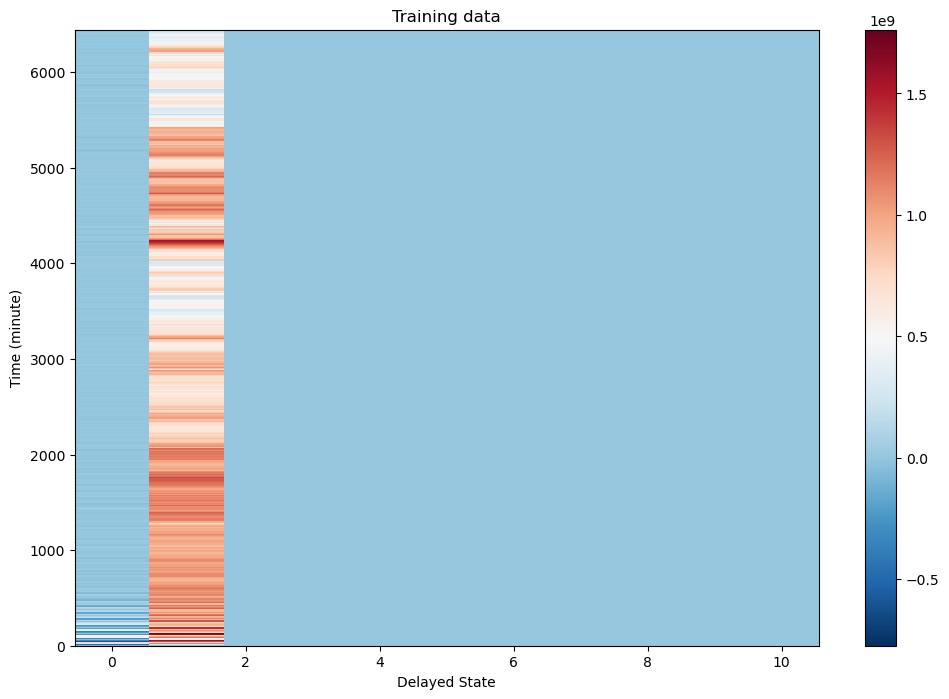

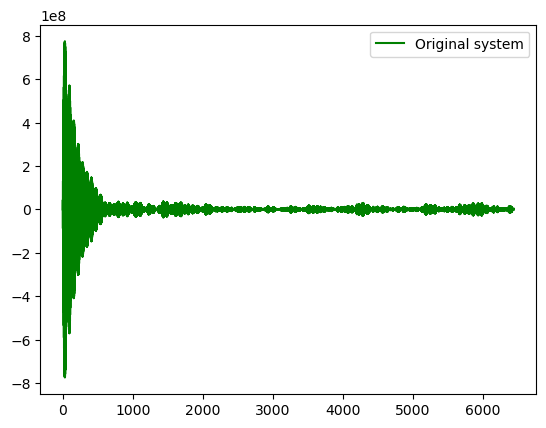

c:\Users\gabri\anaconda3\Lib\site-packages\pydmd\snapshots.py:72: UserWarning: Input data condition number 297155620.88799286. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
c:\Users\gabri\anaconda3\Lib\site-packages\harold\_classes.py:2622: ComplexWarning: Casting complex values to real discards the imaginary part
  np.array(abcd, dtype='float')
c:\Users\gabri\anaconda3\Lib\site-packages\pydmd\snapshots.py:72: UserWarning: Input data condition number 4155961376.725487. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
c:\Users\gabri\anaconda3\Lib\site-packages\harold\_classes.py:2622: ComplexWarning: Casting complex values to real discards the imaginary part
  np.array(abcd, dtype='float')
c:\Users\gabri\anaconda3\Lib\site-packages\pydmd\snapshots.py:72: UserWarning: Input data condition number 35341237524.06048. Consider preprocessing data, passing in augmented data
ma

In [21]:
## Dataset, complex or real
    
#D_mat = scipy.io.loadmat('real_eig_timeseries.mat')
#D_mat_list = [[element for element in upperElement] for upperElement in D_mat['x']]
    
D_mat = scipy.io.loadmat('complex_eig_timeseries.mat')
D_mat_list = [[element for element in upperElement] for upperElement in D_mat['x']]
    
#SRU dataset

D_mat = scipy.io.loadmat('XU_DMDc.mat')
#D_mat_list = [[element for element in upperElement] for upperElement in D_mat['X']]
U_mat_list = [[element for element in upperElement] for upperElement in D_mat['U']]

#to select dataset uncomment one of them and D_mat_list specific for it


#Transform variables to numpy array, allow us to use they in python ambience
D = np.array(D_mat_list)
#U = np.array(U_mat_list)
U = np.array(U_mat_list)[161,:]
#U = np.zeros([D.shape[0], D.shape[1]], dtype='complex')


#Normalization 
#D = scipy.stats.zscore(D)
#U = scipy.stats.zscore(U)


#Establish the number of snapshots for train and test
row_tot = D.shape[0]
column_tot = D.shape[1]

#indicates the percentage of snapshots for train and test
training_mode = 0.9

column_train = int(column_tot * training_mode)

# training snapshots
D_train = D[:,:int((column_train))]
#U_train = U[:,:int(column_train)]            ########### uncomment if U is a matrix and not an array 
U_train = U[:int(column_train)]

# testing snapshots
D_test = D[:,D_train.shape[1]:]
#U_test = U[:,U_train.shape[1]:]
#for the testing mode we take che rest of array that remain from the division for the training 





#this function allow to make plot like image (it is used to plot matrix values)
def make_plot(X, x=None, y=None, figsize=(12, 8), title='', xlabel='Delayed State', ylabel='Time (minute)', vmin = None, vmax = None, ticks = None):
    """
    Plot of the data X
    """
    plt.figure(figsize=figsize)
    plt.title(title)
    X = np.real(X)
    CS = plt.pcolormesh(x, y, X, vmin = vmin, vmax = vmax, cmap= "RdBu_r")
    cbar = plt.colorbar(CS)
    if ticks != None:
        plt.xticks(np.arange(0, len(X[0]), ticks))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


#https://numpy.org/doc/stable/reference/generated/numpy.linspace.html
x_train = np.linspace(0, row_tot, row_tot)
dt0 = 1    #1 minute
t_train = np.linspace(0, int(dt0 * column_train), int(dt0 * column_train))

make_plot(D_train.T, x=x_train, y=t_train, title = 'Training data')


#plot the first column of the dataset selected
plt.figure()
plt.plot(t_train, D_train[0,:], 'g', label='Original system')
plt.legend()
plt.show()




#this function make a comparison between the first column of the original system and the reconstructed system
def comparison(D, D_mrdmdc_level, level):
        D0 = D[0,:]
        D_0 = D_mrdmdc_level[0,:]

        t_train = D0.shape[0]
        t_train = np.linspace(0, t_train, t_train)
    
        plt.figure()
        plt.plot(t_train, D0.real, 'b', label='Misura')
        plt.plot(t_train, D_0.real, 'g', label='mrDMDc level: ' + str(level))
        plt.legend()
        plt.show()












def mrdmdc(D, U, level=0, bin_num=0, offset=0, max_levels=20, max_cycles=10):
    """Compute the multi-resolution DMD on the dataset `D`, returning a list of nodes
    in the hierarchy. Each node represents a particular "time bin" (window in time) at
    a particular "level" of the recursion (time scale). The node is an object consisting
    of the various data structures generated by the DMD at its corresponding level and
    time bin. The `level`, `bin_num`, and `offset` parameters are for record keeping 
    during the recursion and should not be modified unless you know what you are doing.
    The `max_levels` parameter controls the maximum number of levels. The `max_cycles`
    parameter controls the maximum number of mode oscillations in any given time scale 
    that qualify as "slow". The `do_svht` parameter indicates whether or not to perform
    optimal singular value hard thresholding."""
     
    
    # 4 times nyquist limit to capture cycles                 
    nyq = 4 * max_cycles                                      

    
    #bin_size is equal to number of columns of D
    bin_size = D.shape[1]                          


    #the condition for exit from algorithm
    if (bin_size) < (nyq):                                        
        return []


    # extract subsamples, take a value every step for D and U
    #step = floor(bin_size / nyq)     #floor truncate the decimal part of number   
    step = bin_size // nyq        
    _D = D[:,::(step)]                                           
    #_U = U[:,::(step)]             #################
    _U = U[::(step)]
    




    #Plot of subsampled data
    x = _D.shape[0]
    y = _D.shape[1]
    x = np.linspace(0, x, x)
    y = np.linspace(0, y, y)
    #make_plot(D0.T, x=x, y=y, title=" nyq: " + str(nyq) + " step: " + str(step), figsize=(7.5, 5))




    

    #declaration of DMDc object, it will be used to calculate eigenvalues and modes, also keeps track of the algorithm iterations and allow to save the reconstructed matrix for each iteration
    dmdc = DMDc(svd_rank=-1) 


    dmdc.level = level            # level of recursion
    dmdc.bin_num = bin_num        # time bin number
    dmdc.bin_size = bin_size      # time bin size
    dmdc.start = offset           # starting index
    dmdc.stop = offset + bin_size # stopping index
    dmdc.step = step              # step size
    dmdc.nyq = nyq


    #fitting model from data and input passed to algorithm, take one snapshot less than D
    #dmdc.fit(_D , _U[:,1:])          ###################
    dmdc.fit(_D , _U[1:])


    #extract eigenvalues and modes from DMDc object
    mu = dmdc.eigs
    Phi = dmdc.modes


    #Slow filtration
    rho = 11*max_cycles / bin_size                               
    dmdc.rho = rho


    # consolidate slow eigenvalues (as boolean mask)
    slow = (np.abs(np.log(mu) / (2 * pi * step))) <= rho
        

    # number of slow modes
    n = sum(slow)                        


    #calculate the percentage of filtration 100 : mu = percentage_of_filtration : n
    dmdc.percentage_of_filtration = 100 - ((100/len(mu)) * n)


    # extract slow modes (perhaps empty)                       
    mu_SLOW_step = mu[slow]                                               
    Phi_SLOW_step = Phi[:,slow]                                          
    

    #if found slow mode...
    if n > 0:                                                  

        #Calculate A with slow features, they were calcuted with dt = step 
        A_disc_step = np.linalg.multi_dot(                                                  
            [Phi_SLOW_step, np.diag(mu_SLOW_step), np.linalg.pinv(Phi_SLOW_step)]    
        )


        #Extract B from dmdc object, also calculate with dt = step by method .fit (when we call dmdc.fit)         
        B_disc_step = dmdc.B


        #Considerate two matrices C and D
        #matrix C with a ones column and the rest with 0 to extract the first state (that is not delayed) 
        C_disc = np.zeros([A_disc_step.shape[0],B_disc_step.shape[0]], dtype = 'complex')
        C_disc[:,0] = 1

        #matrix D with 0 because the inputs don't influence directly the exit (strictly own system)
        #D_disc = np.zeros([A_disc_step.shape[0], B_disc_step.shape[1]], dtype = 'complex')            ##########################
        D_disc = np.zeros([A_disc_step.shape[0]], dtype = 'complex')
        
        
        #generate a discrete system with dt = step, because we want to see eigenvalues in continuous
        sys_disc_step = harold.State(A_disc_step, B_disc_step , C_disc, D_disc, dt = (step))


        #to see eigenvalues in continuous used the method of the Harold library "undiscretize" that allow to pass from dicrete system to continuous system 
        sys_cont = harold.undiscretize(sys_disc_step, method='tustin')  
        #extract matrices from continuous system
        A_cont = sys_cont.a
        B_cont = sys_cont.b
        C_cont = sys_cont.c
        D_cont = sys_cont.d
        #calculate eigenvalues from A matrix
        [dmdc.mu_SLOW_cont,eigenvectors] = eig(A_cont)


        #to print pzmap (pole-zero map) about system, there is the necessity to use another library because Harold library don't support the pzmap method
        #the library that allow to see pzmap is the "Control Library for Python" doc: https://python-control.readthedocs.io/en/0.9.4/index.html
        sys_cont_control = ct.StateSpace(A_cont, B_cont, C_cont, D_cont)    
        #ct.pzmap(sys_cont_control)
        #plt.show()
        
        
        #for the reconstruction there is a necessity to reconvert system in discrete state, but with dt = 1 because every sample must be rescaled from distance step to 1
        sys_disc_1 = harold.discretize(sys_cont, dt = 1, method = 'tustin')

        #extract matrices, they are used to reconstruct 
        A_disc_1 = sys_disc_1.a
        #B_disc_1 = sys_disc_1.b       #######################  if U is a column, comment the instruction in this row and uncomment the one immediately below.   
        B_disc_1 = sys_disc_1.b[:,0]       ############################ COMMENTO DA CANCELLARE -> va bene come assegnazione da riga a colonna

        #extraction of eigenvalues with dt = 1
        [dmdc.mu_SLOW_1,eigenvectors] = eig(A_disc_1)
        
        '''Now the algorithm have the matrices A and B to compute the reconstructed matrix for the node (DMDc object)'''
        
        #the reconstruction for one node starts from the initial conditions (delcared as an array). This array will become a matrix after the reconstruction code block
        D_dmdc_disc_1 = [D[:, 0]].copy()

        D_dmdc_A_disc_1 = D_dmdc_disc_1.copy()    
        D_dmdc_B_disc_1 = []  #np.zeros([D_dmdc_cont[0].shape[0]])

        #number of rows expected after the reconstruction
        expected_shape = D_dmdc_disc_1[0].shape
        
        

        #the reconstruction continue with the calculation about data and inputs like DMDc algorithm but with the difference that the reconstrution is with all inputs and not only subsampled inputs
        #data[i] rappresenta l'istante i-esimo dei dati dello stato      #######################DA TRADURRE
        #u rappresenta l'istante i-esimo dei dati di input
        #for i, u in enumerate(U[:,1:].T):            #########################
        for i, u in enumerate(U[1:].T):
            arr = (A_disc_1.dot(D_dmdc_disc_1[i])) + (B_disc_1.dot(u))  

            x = A_disc_1.shape[0]
            y = A_disc_1.shape[1]
            x = np.linspace(0, x, x)
            y = np.linspace(0, y, y)
            #make_plot(A_disc_1, x=y, y=x, title=   'A_disc_1' + " nyq: " + str(nyq) + " step: " + str(step), figsize=(7.5, 5))

            x = A_disc_step.shape[0]
            y = A_disc_step.shape[1]
            x = np.linspace(0, x, x)
            y = np.linspace(0, y, y)
            #make_plot(A_disc_step, x=y, y=x, title="A_disc_step nyq: " + str(nyq) + " step: " + str(step), figsize=(7.5, 5))

            x = A_cont.shape[0]
            y = A_cont.shape[1]
            x = np.linspace(0, x, x)
            y = np.linspace(0, y, y)
            #make_plot(A_cont, x=y, y=x, title="A_cont nyq: " + str(nyq) + " step: " + str(step), figsize=(7.5, 5))

            #arr = A_disc_step.dot(D_dmdc_disc_1[i]) + B_disc_step.dot(u)
            if arr.shape != expected_shape:
                raise ValueError(
                    f"Invalid shape: expected {expected_shape}, got {arr.shape}"
                ) 
            D_dmdc_disc_1.append(arr)
            D_dmdc_A_disc_1.append(A_disc_1.dot(D_dmdc_disc_1[i]))
            D_dmdc_B_disc_1.append(B_disc_1.dot(u))

        D_dmdc_disc_1 = np.array(D_dmdc_disc_1).T
        D_dmdc_A_disc_1 = np.array(D_dmdc_A_disc_1).T
        D_dmdc_B_disc_1 = np.array(D_dmdc_B_disc_1).T
        


        #D_dmdc_A_disc_1 = dot(A_disc_1, D)
        #D_dmdc_B_disc_1 = dot(B_disc_1, U)
        #D_dmdc_disc_1 = D_dmdc_A_disc_1 + D_dmdc_B_disc_1


        '''
        plt.figure(figsize=(16,6))
        x = np.linspace(0, D_dmdc_A_disc_1.shape[1], D_dmdc_A_disc_1.shape[1])
        plt.plot(x, D_dmdc_A_disc_1[0,:], label='D_dmdc_A level: ' + str(level))
        plt.legend()
        plt.show() 
        '''                       

        #save the continuous system to see zeros poles for every level
        dmdc.sys_cont = sys_cont
        #save discrete system with dt = 1
        dmdc.sys_disc_1 = sys_disc_1



    else:
        #reassignments of A,B are made in case no SLOW features are found
        D_dmdc_A_disc_1 = np.zeros([D.shape[0], D.shape[1]], dtype='complex')
        D_dmdc_B_disc_1 = np.zeros([D.shape[0], D.shape[1]], dtype='complex')

        D_dmdc_disc_1 = np.zeros([D.shape[0], D.shape[1]], dtype='complex')

   
    dmdc.D_dmdc_A_disc_1 = D_dmdc_A_disc_1
    dmdc.D_dmdc_B_disc_1 = D_dmdc_B_disc_1



    #x = D_dmdc_disc_1.shape[0]
    #y = D_dmdc_disc_1.shape[1]
    #x = np.linspace(0, x, x)
    #y = np.linspace(0, y, y)
    #make_plot(D_dmdc.T, x=x, y=y, title='levels 0-' + str(level) + " nyq: " + str(nyq) + " step: " + str(step), figsize=(7.5, 5))
    #plt.figure()
    #plt.plot(y, D_dmdc_A[0,:], 'b', label='D_dmdc_A')
    #plt.plot(y, D_dmdc_B[0,:], 'g', label='D_dmdc_B')
    #plt.legend()
    #plt.show()

    # remove influence of slow modes
    D = D - D_dmdc_disc_1                                                   
   
    #save matrix for the reconstruction
    dmdc.dato = D_dmdc_disc_1

    #save eigenvalues and modes with dt = step
    dmdc.mu_SLOW_step = mu_SLOW_step
    dmdc.phi_SLOW_step = Phi_SLOW_step

    #save the DMDc object into an array
    nodes = [dmdc]


    #the code will iterate splitting the data and input, stopping if level = max_levels or return when bin_size < nyq
    if level < max_levels:
        split = floor(bin_size / 2) # where to split           ## ceil(x) approximate by excess
        nodes += mrdmdc(
            D[:,:split],
            #U[:,:split],                          ##################################
            U[:split],
            level=level+1,
            bin_num=2*bin_num,
            offset=offset,
            max_levels=max_levels,
            max_cycles=max_cycles,
            )
        nodes += mrdmdc(
            D[:,split:],
            #U[:,split:],                        #########################
            U[split:],
            level=level+1,
            bin_num=2*bin_num+1,
            offset=offset+split,
            max_levels=max_levels,
            max_cycles=max_cycles,
            )
        #With every iteration of the algorithm there is an addition of a node (that is a DMDc object) in an array
        #At the end the algorithm return the array with nodes processed in all iterations
    return nodes


nodes = mrdmdc(D_train, U_train)



    


'''
def dimensionamento(dataset, column):

    #this function allow to plot the graphic of the system during his reconstruction with the dimension of the original system
    #an example a matrix 40x4 become 40x7160 

    # Calcola il fattore di ripetizione per ogni colonna
    fattore_ripetizione = math.ceil(column / dataset.shape[1])    #approssimo per eccesso 
    # Espandi le colonne della matrice
    matrice_finale = np.repeat(dataset, fattore_ripetizione, axis=1)
    # Riduci le colonne al numero desiderato
    matrice_finale = matrice_finale[:, :column]         #qui mi faccio il troncamento
    
    return matrice_finale
'''




def iteration_level(nodes):
    #this function allow to know the level of iterations that mrdmdc done
    level = 0
    for n in nodes:
        if n.level > level:
            level = n.level
    return int(level) 



c:\Users\gabri\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\gabri\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


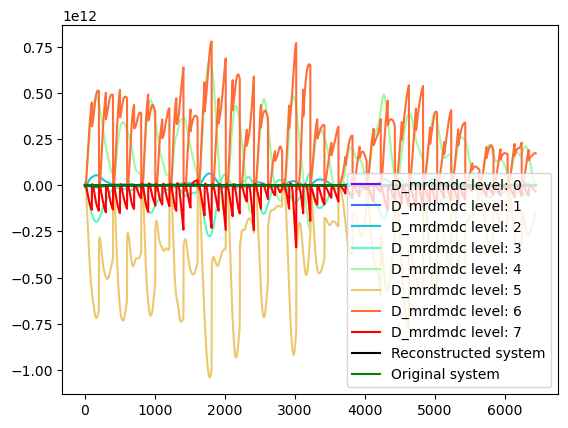

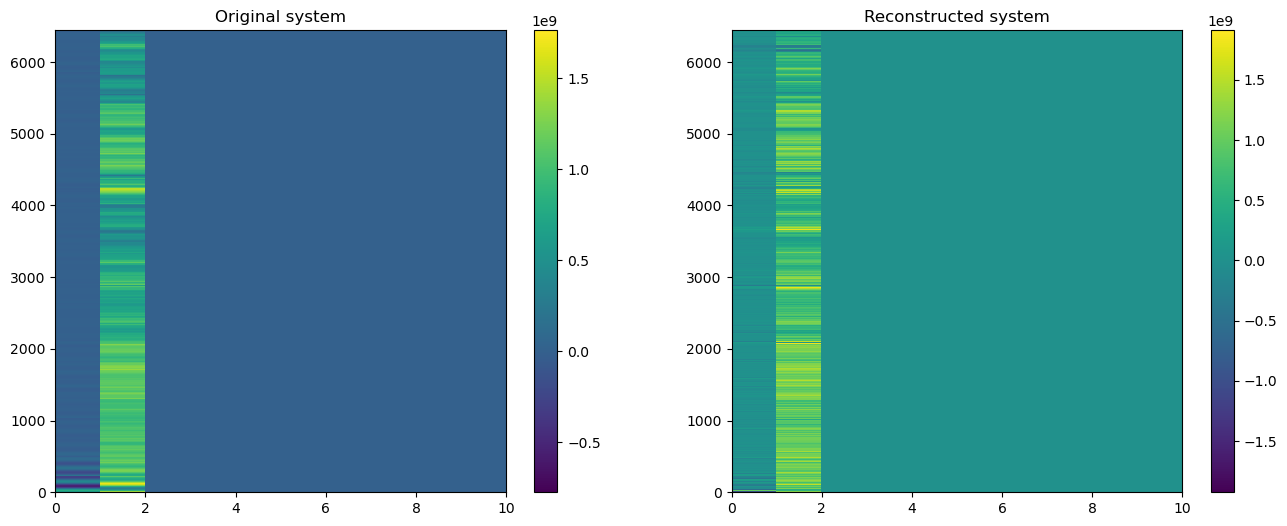

MSE:
9830774367435530.0
MAPE: 
434.7372161964527 %
MAE: 
24299859.02773848
RMSE: 
99150261.5600964
R2: 
-0.7207123800410187


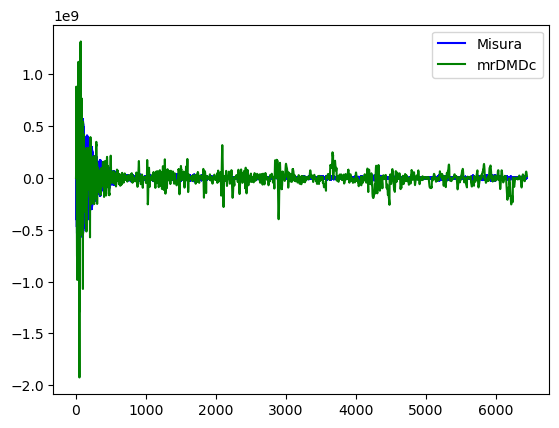

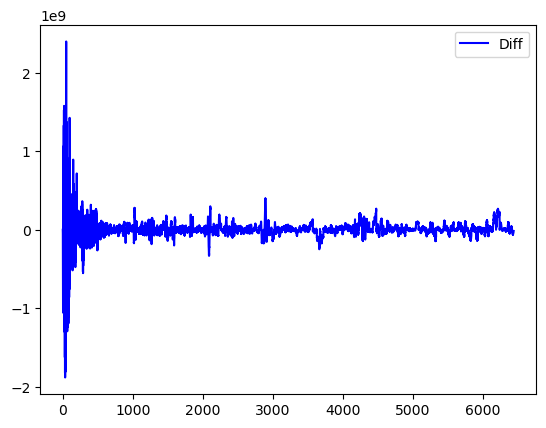

In [22]:

# start the reconstruction of data train
colors = plt.cm.rainbow(np.linspace(0, 1, iteration_level(nodes) + 1))

#declare variable that filled up in the reconstruction
D_mrdmdc = np.zeros([row_tot, column_train], dtype = complex)    
D_mrdmdc_A = np.zeros([row_tot, column_train], dtype = complex)
D_mrdmdc_B = np.zeros([row_tot, column_train], dtype = complex)

for level in range(0 , iteration_level(nodes) + 1):

    # extract and sort relevant nodes of single level 
    nodes_level = [n for n in nodes if n.level == level]
    nodes_level = sorted(nodes_level, key=lambda n: n.bin_num)

    #horizontal stack of reconstructed matrices of nodes with same level (stack reconstructed snapshots in order)
    D_mrdmdc_level_reconstruction = np.hstack([n.dato for n in nodes_level])
    
    #sum every reconstructed level 
    D_mrdmdc += D_mrdmdc_level_reconstruction

    #save step and nyq values, they can be seen in the plots
    nyq = nodes_level[0].nyq
    step = nodes_level[0].step

    #plots of the reconstruction matrix and of the first column (during the reconstruction)
    x = D_mrdmdc.shape[0]
    y = D_mrdmdc.shape[1]
    x = np.linspace(0, x, x)
    y = np.linspace(0, y, y)
    #make_plot(D_mrdmdc.T, x=x, y=y, title='levels 0-' + str(level) + " nyq: " + str(nyq) + " step: " + str(step), figsize=(7.5, 5))
    #comparison(D_train, D_mrdmdc, level)


#this part helps to see all reconstructed matrices of levels in one plot 
D_mrdmdc = np.zeros([row_tot, column_train], dtype = complex)    
plt.figure()

for level in range(0 , iteration_level(nodes) + 1):

    # extract relevant nodes
    nodes_level = [n for n in nodes if n.level == level]
    nodes_level = sorted(nodes_level, key=lambda n: n.bin_num)

    D_mrdmdc_level_reconstruction = np.hstack([n.dato for n in nodes_level])

    plt.plot(t_train, D_mrdmdc_level_reconstruction[0,:], color=colors[level], label='D_mrdmdc level: ' + str(level))

    D_mrdmdc += D_mrdmdc_level_reconstruction

    nyq = nodes_level[0].nyq
    step = nodes_level[0].step

plt.plot(t_train, D_mrdmdc[0,:], 'k', label='Reconstructed system')

plt.plot(t_train, D_train[0,:], 'g', label='Original system')
plt.legend()
plt.show()


#this part helps to see A*X and B*U of each levels
'''
colors = plt.cm.rainbow(np.linspace(0, 1, iteration_level(nodes) + 1)) 

for level in range (0, iteration_level(nodes) + 1):
    nodes_level = [n for n in nodes if n.level == level]
    nodes_level = sorted(nodes_level, key=lambda n: n.bin_num)

    D_mrdmdc_level_A = np.hstack([n.D_dmdc_A_disc_1 for n in nodes_level])
    plt.figure(figsize=(16,6))
    plt.subplot(121)
    plt.plot(t_train, D_mrdmdc_level_A[0,:], color=colors[level], label='D_mrdmdc_A level: ' + str(level))
    plt.legend()

    D_mrdmdc_level_B = np.hstack([n.D_dmdc_B_disc_1 for n in nodes_level])
    plt.subplot(122)
    plt.plot(t_train, D_mrdmdc_level_B[0,:], color=colors[level], label='D_mrdmdc_B level: ' + str(level))
    plt.legend()
    plt.show()
'''

    







#Comparison between original data and reconstructed data
plt.figure(figsize=(16, 6))

plt.subplot(121)
plt.title("Original system")
plt.pcolor(D_train.real.T)
plt.colorbar()

plt.subplot(122)
plt.title("Reconstructed system")
plt.pcolor(D_mrdmdc.real.T)
plt.colorbar()

plt.show()




def mean_squared_error(y_true, y_pred):
    """
    Funzione che calcola MSE.
    :param y_true: lista di numeri che rappresentano i valori reali
    :param y_pred: lista di numeri che rappresentano i valori predetti
    :restituisce: MSE
    """
    return np.mean(np.abs(np.array(y_pred) - np.array(y_true))**2)

def MAPE (Y_actual,Y_Predicted):   #MEAN ABSOLUTE PERCENTAGE ERROR
    mape = np.mean(np.abs((np.array(Y_actual) - np.array(Y_Predicted))/np.array(Y_actual)))*100
    return mape

def MAE(y_true, y_pred):     #MEAN ABSOLUTE ERROR
    mae_value = np.mean(np.abs(np.array(y_pred) - np.array(y_true)))
    return mae_value

def RMSE(y_true, y_pred):     #ROOT MEAN SQUARED ERROR
    rmse_value = np.sqrt(np.mean((np.array(y_pred) - np.array(y_true))**2))
    return rmse_value

from sklearn.metrics import r2_score
def R2(y_true, y_pred):
    r2_value = r2_score(np.array(y_pred.real), np.array(y_true.real))
    return r2_value


 
print("MSE:")
print((mean_squared_error(D_mrdmdc.real.T,D_train.real.T)))
print ("MAPE: ")
print (MAPE(D_mrdmdc.real.T , D_train.real.T),"%")
print ("MAE: ")
print(MAE(D_mrdmdc.real.T , D_train.real.T))
print ("RMSE: ")
print(RMSE(D_mrdmdc.real.T , D_train.real.T))
print ("R2: ")
print(R2(D_mrdmdc.real.T , D_train.real.T))



plt.figure()
plt.plot(t_train, D_train.real[0,:], 'b', label='Misura')
plt.plot(t_train, D_mrdmdc.real[0,:], 'g', label='mrDMDc')
plt.legend()
plt.show()

plt.figure()
error=np.array(D_train) - np.array(D_mrdmdc)
plt.plot(t_train, error.real[0,:], 'b', label='Diff')
plt.legend()
plt.show()

In [23]:
# helps to set 0 value with withe colour
def max_value(matrix):
    max_value = np.max([np.max(matrix)])
    min_value = np.min([np.min(matrix)])
    if (max_value >= -(min_value)):
        scale = max_value
    else:
        scale = -min_value
    return scale


#plot of B, A_tilde, A for each level
for level in range (0, iteration_level(nodes) + 1):
    nodes_level_B = []
    nodes_level_A_tilde = []
    nodes_level_A = []
    for n in nodes:
        if n.level == level:
            nodes_level_B.append(n.B.real)
            nodes_level_A_tilde.append(n._Atilde._Atilde)       # n.A_tilde is an object of class DMDcUnkonwnOperator, n.A_tilde.A_tilde is the matrix
            nodes_level_A.append(n.A)
 
    sum_level_B = sum(nodes_level_B)
    mean_level_B = sum_level_B / len(nodes_level_B)
    x = np.linspace(0, mean_level_B.shape[0], mean_level_B.shape[0])
    y = np.linspace(0, mean_level_B.shape[1], mean_level_B.shape[1])
    
    scale_B = max_value(mean_level_B)
    #make_plot(mean_level_B, x=y, y=x, title = 'Mean _B level: ' + str(level), xlabel = 'Input', ylabel = 'Output', vmin = -(scale_B), vmax = (scale_B), ticks = 40)    #self.B

    #the sum of A_tilde works only if A_tilde is not truncated (svd_rank = -1) and also if the parameter max_cycles allow to have _D with shape[1] > shape[2] 
    '''
    sum_level_A_tilde = sum(nodes_level_A_tilde)
    mean_level_A_tilde = sum_level_A_tilde / len(nodes_level_A_tilde)
    x = np.linspace(0, mean_level_A_tilde.shape[0], mean_level_A_tilde.shape[0])
    y = np.linspace(0, mean_level_A_tilde.shape[1], mean_level_A_tilde.shape[1])

    scale_A_tilde = max_value(mean_level_A_tilde)
    make_plot(mean_level_A_tilde, x=y, y=x, title = 'Mean A_tilde level: ' + str(level), xlabel = 'State', ylabel = 'Output', vmin = -(scale_A_tilde), vmax = (scale_A_tilde))   #self._Atilde
    '''

    '''
    sum_level_A = sum(nodes_level_A)
    mean_level_A = sum_level_A / len(nodes_level_A)
    x = np.linspace(0, mean_level_A.shape[0], mean_level_A.shape[0])
    y = np.linspace(0, mean_level_A.shape[1], mean_level_A.shape[1])

    scale_A = max_value(mean_level_A)
    #make_plot(mean_level_A, x=y, y=x, title = 'Mean A level: ' + str(level), xlabel = 'State', ylabel = 'Output', vmin = -(scale_A), vmax = (scale_A))   #self.A
    '''

In [24]:
#plot of A_tilde and B for each node
for level in range (0, 3):
    count = 0
    for node in nodes:
        if node.level == level:
            x = np.linspace(0, node.B.shape[0], node.B.shape[0])
            y = np.linspace(0, node.B.shape[1], node.B.shape[1])

            scale_B = max_value(node.B)
            #make_plot(node.B, x=y, y=x, title='B level: ' + str(level) + ' Node: ' + str(count), xlabel = 'Input', ylabel = 'Output',  vmin = -(scale_B), vmax = (scale_B))

            x = np.linspace(0, node._Atilde._Atilde.shape[0], node._Atilde._Atilde.shape[0])
            y = np.linspace(0, node._Atilde._Atilde.shape[1], node._Atilde._Atilde.shape[1])

            scale_A_tilde = max_value(node._Atilde._Atilde)
            #make_plot(node._Atilde._Atilde, x=y, y=x, title='A_tilde level: ' + str(level) + ' Node: ' + str(count), xlabel = 'State', ylabel = 'Output', vmin = -(scale_A_tilde), vmax = (scale_A_tilde))
        count = count + 1



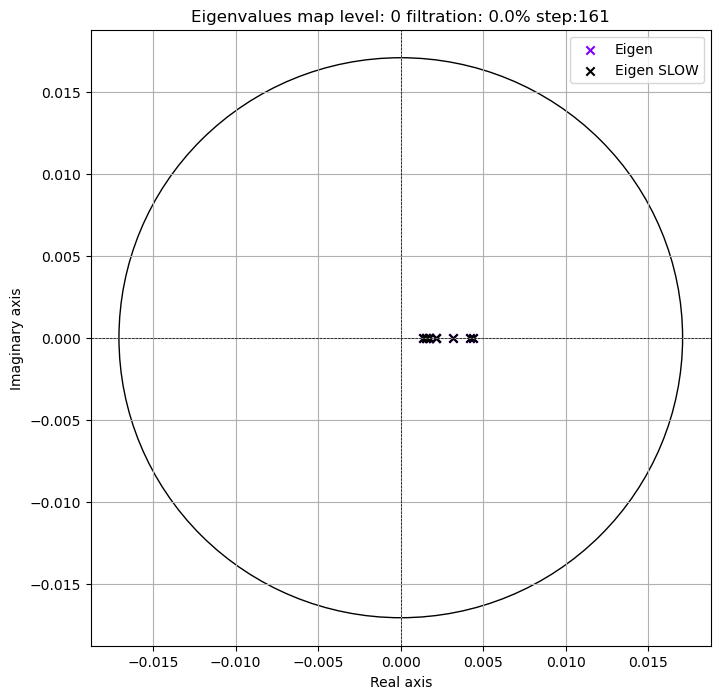

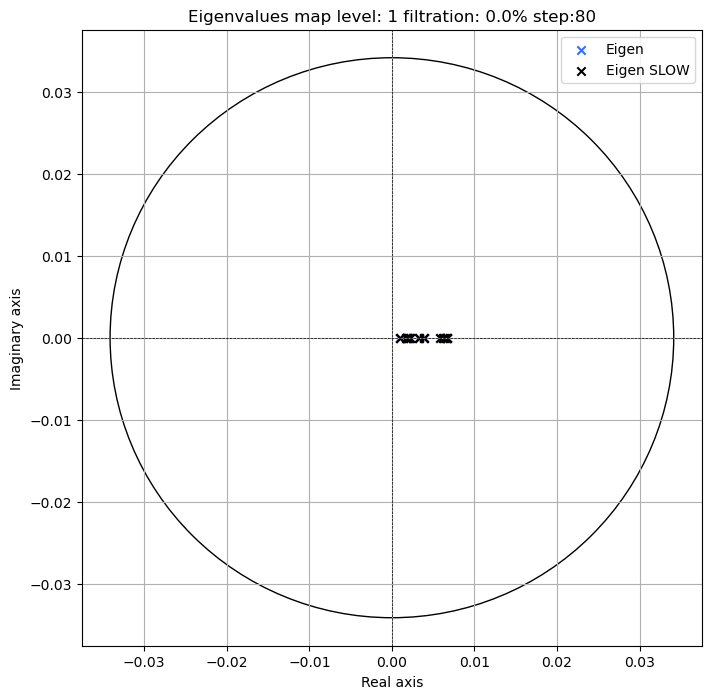

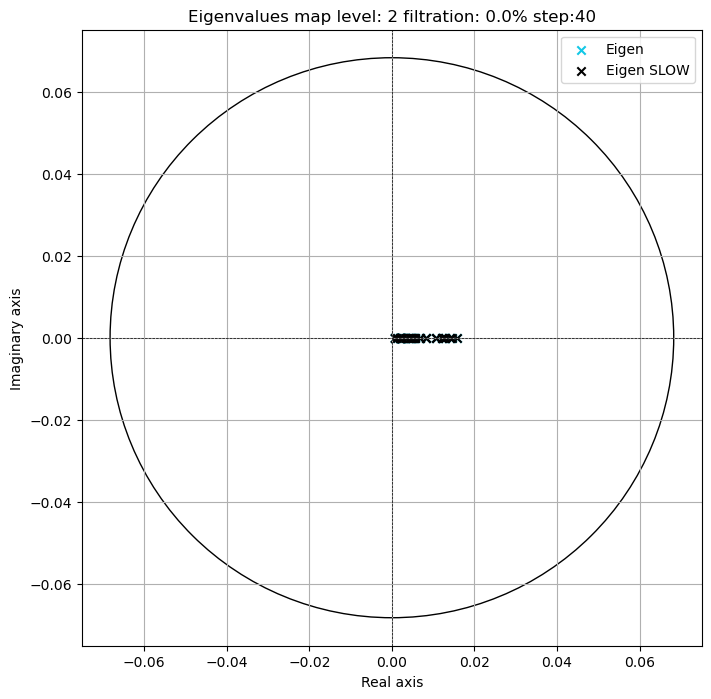

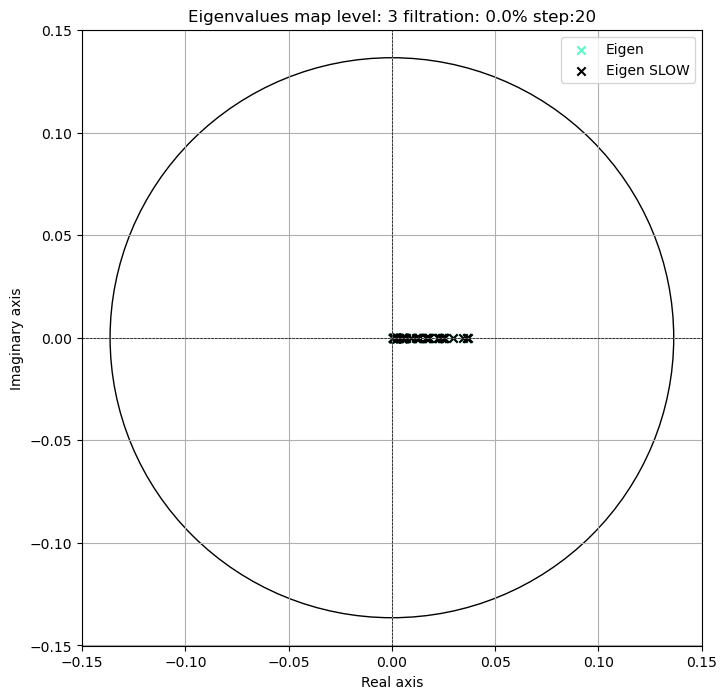

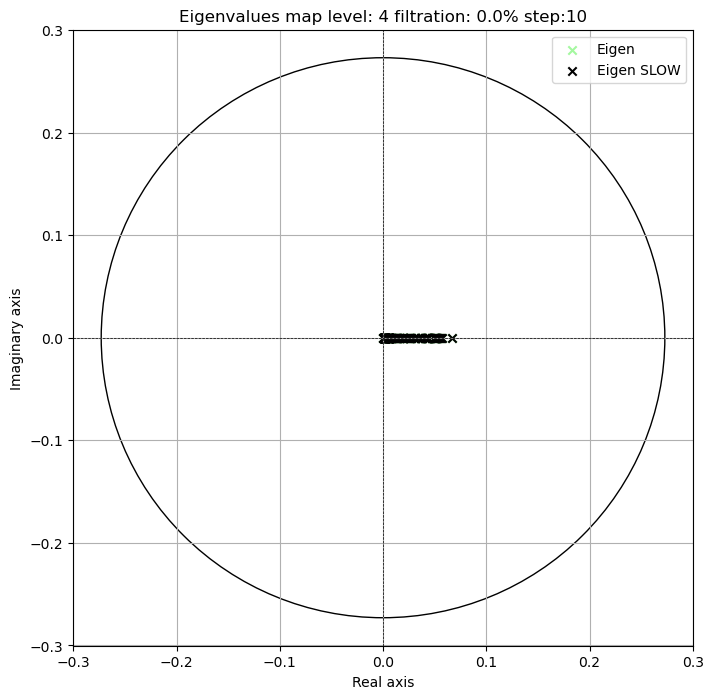

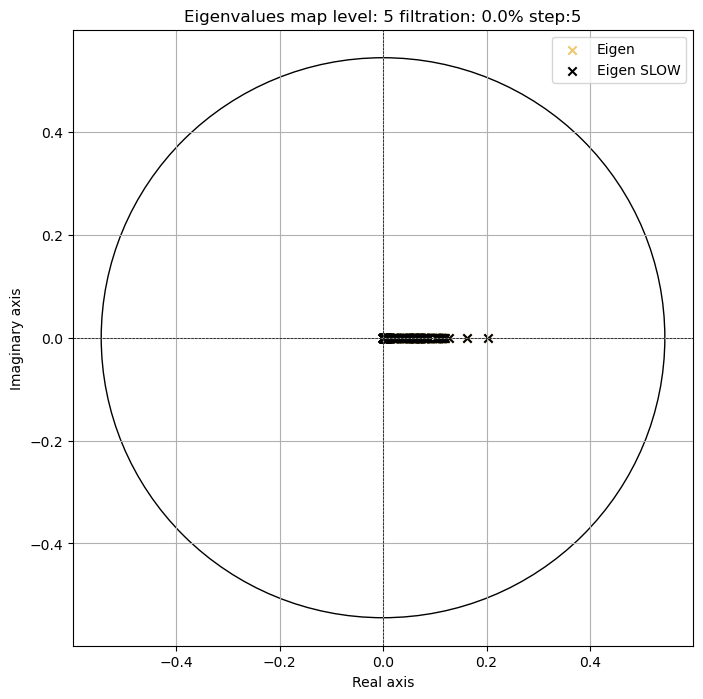

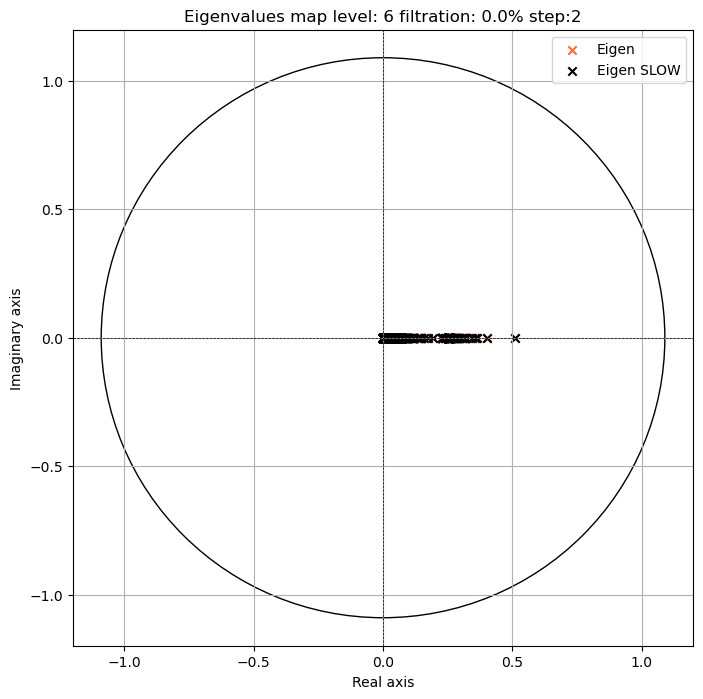

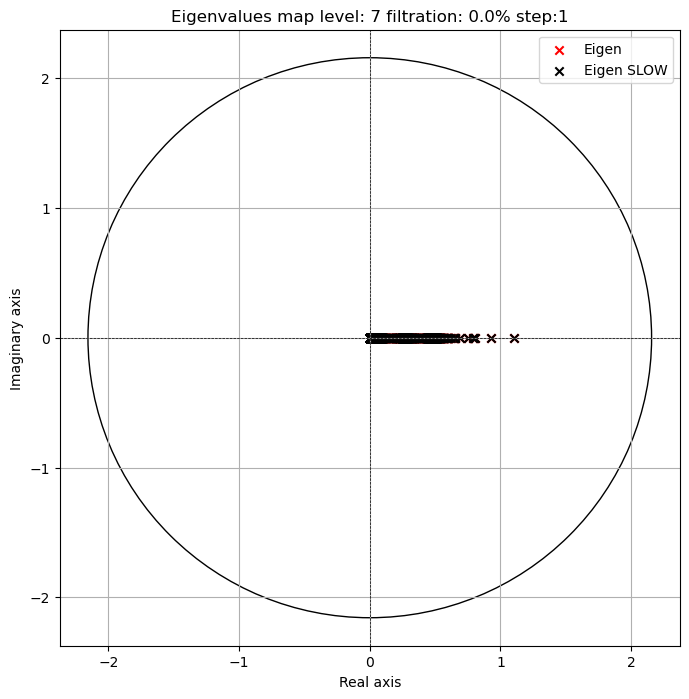

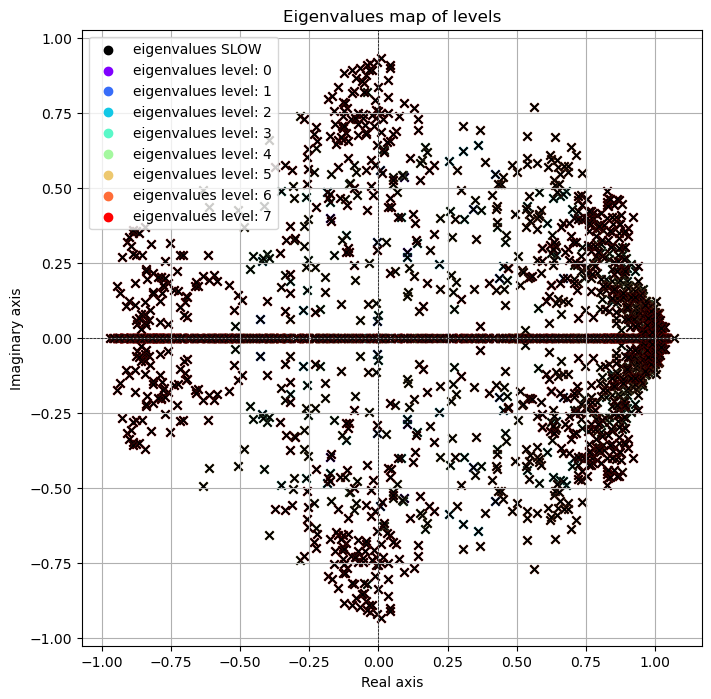

In [25]:
#plots of eigenvalues with dt = step before the SLOW filtration and after, with the percentage of filtration for each levels, one level in one plot
colors = plt.cm.rainbow(np.linspace(0, 1, iteration_level(nodes) + 1))
for level in range (0, iteration_level(nodes) + 1):
    #declaration of lists that will filled up for the plots
    eigenvalues = []
    eigenvalues_SLOW = []
    filtration = []
    for node in nodes:
        if node.level == level:
            #when node.level == level save eigenvalues before the filtration and after it, this allow to plot all eigenvalues of each level in the same plot
            step = node.step
            rho = node.rho
            eigenvalues.extend((np.abs(np.log(node.eigs) / (2 * pi * step))))
            eigenvalues_SLOW.extend((np.abs(np.log(node.mu_SLOW_step) / (2 * pi * step))))
            filtration.extend([node.percentage_of_filtration])


    real_part_eigenvalues = np.real(eigenvalues)
    imag_part_eigenvalues = np.imag(eigenvalues)

    real_part_eigenvalues_SLOW = np.real(eigenvalues_SLOW)
    imag_part_eigenvalues_SLOW = np.imag(eigenvalues_SLOW)

    percentage_of_filtration = sum(filtration) / len(filtration)
    
    
    plt.figure(figsize=(8, 8))

    #also plot the circle to see wich eigenvalues was chosen like SLOW
    circle = plt.Circle([0,0], radius = rho, fill = False)
    plt.gca().add_patch(circle)

    plt.scatter(real_part_eigenvalues, imag_part_eigenvalues, marker='x', color=colors[level], label='Eigen')
    plt.scatter(real_part_eigenvalues_SLOW, imag_part_eigenvalues_SLOW, color = 'black', marker='x', label='Eigen SLOW')

    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.axvline(0, color='black', linewidth=0.5, linestyle='--')

    plt.title('Eigenvalues map level: ' + str(level) + ' filtration: ' + str(percentage_of_filtration) + '%' + ' step:' + str(step))
    plt.xlabel('Real axis')
    plt.ylabel('Imaginary axis')
    plt.legend()

    plt.grid(True)
    plt.show()







#plot of eigenvalues and eigenvalues SLOW with dt = step, all levels in one single plot
colors = plt.cm.rainbow(np.linspace(0, 1, iteration_level(nodes) + 1))

plt.figure(figsize=(8, 8))
plt.scatter([],[], color = 'black', label = "eigenvalues SLOW")

for level in range(iteration_level(nodes) + 1):
    plt.scatter([],[], color = colors[level], label = "eigenvalues level: " + str(level))
    for node in nodes:
        if node.level == level:
            plt.scatter(node.eigs.real, node.eigs.imag, marker='x', color=colors[level])
            plt.scatter(node.mu_SLOW_step.real, node.mu_SLOW_step.imag, color = 'black', marker='x')


plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')

plt.title('Eigenvalues map of levels')
plt.xlabel('Real axis')
plt.ylabel('Imaginary axis')
plt.legend()

plt.grid(True)
plt.show()




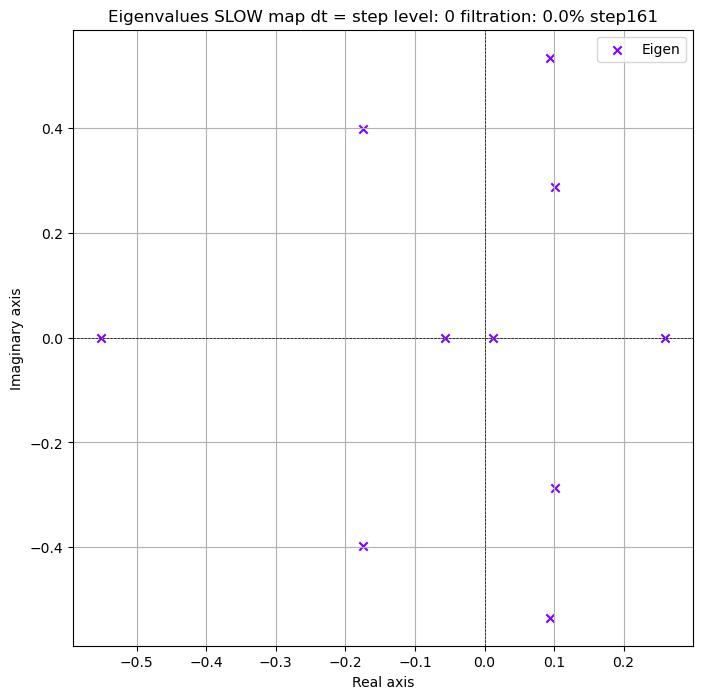

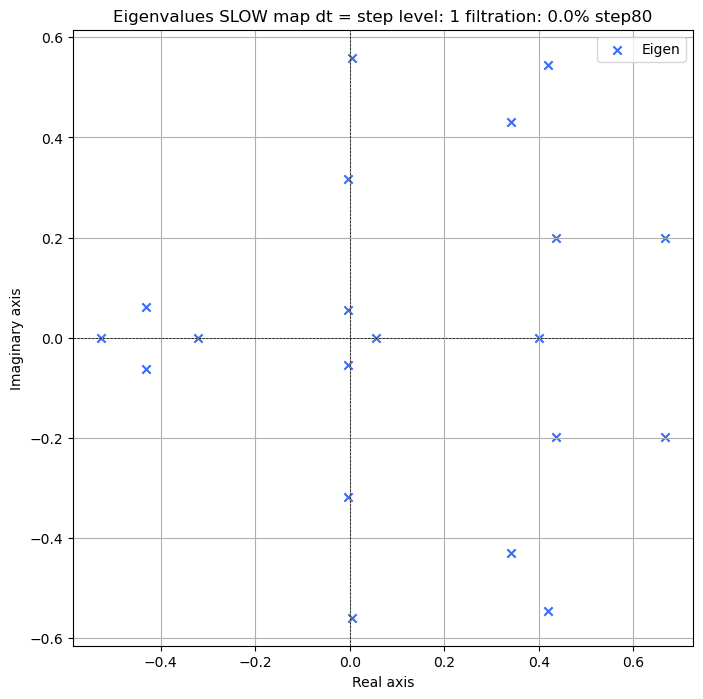

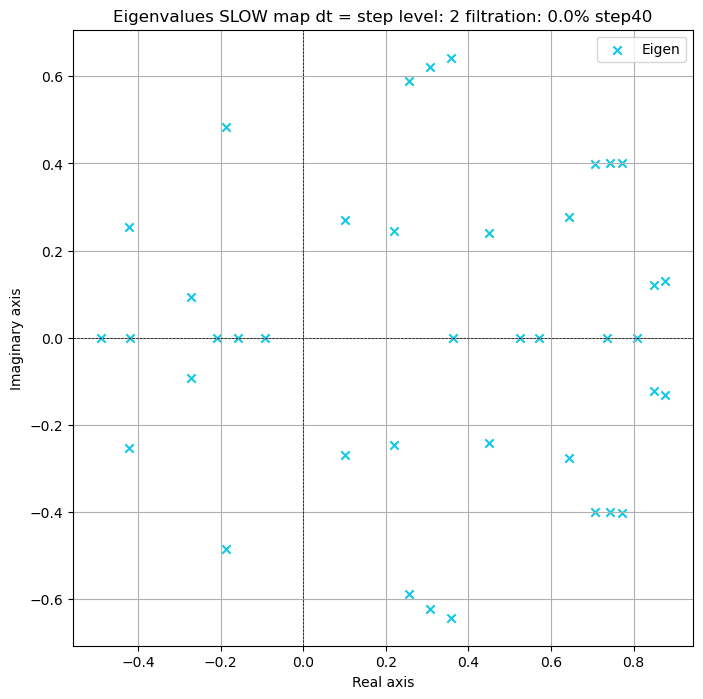

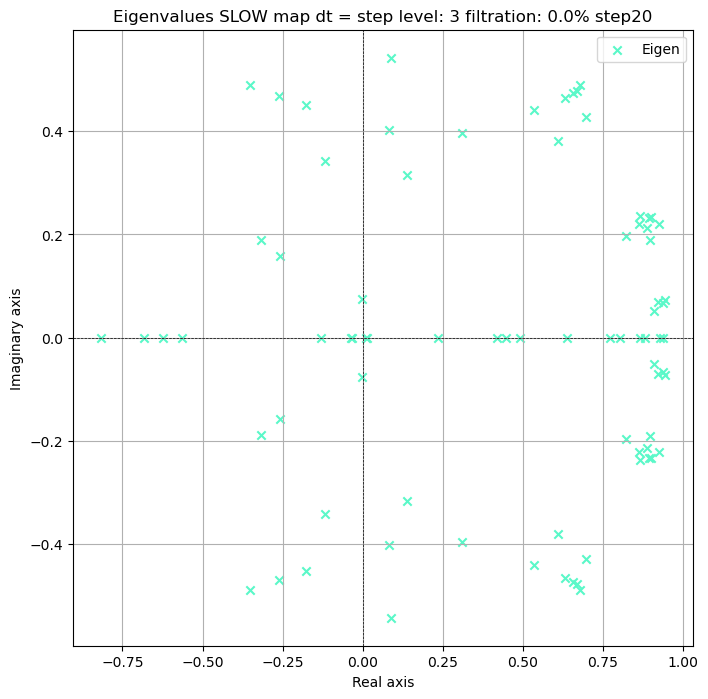

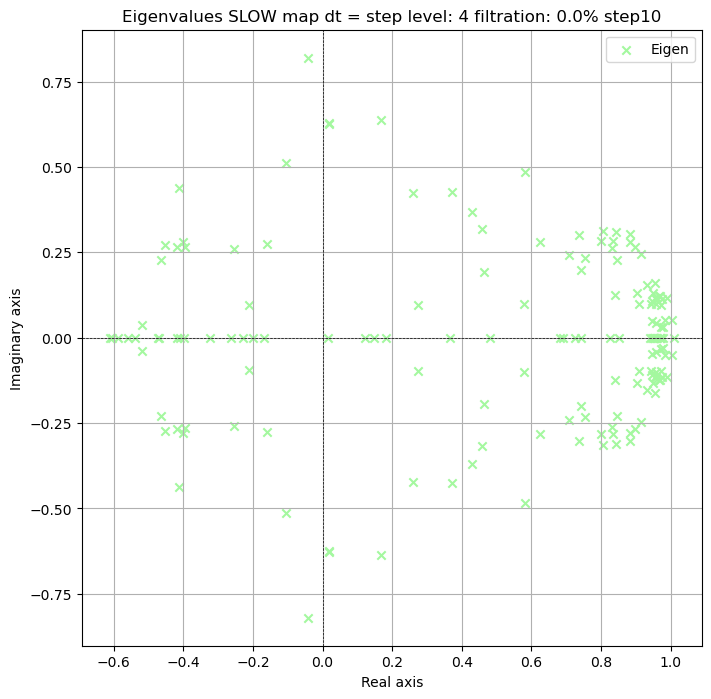

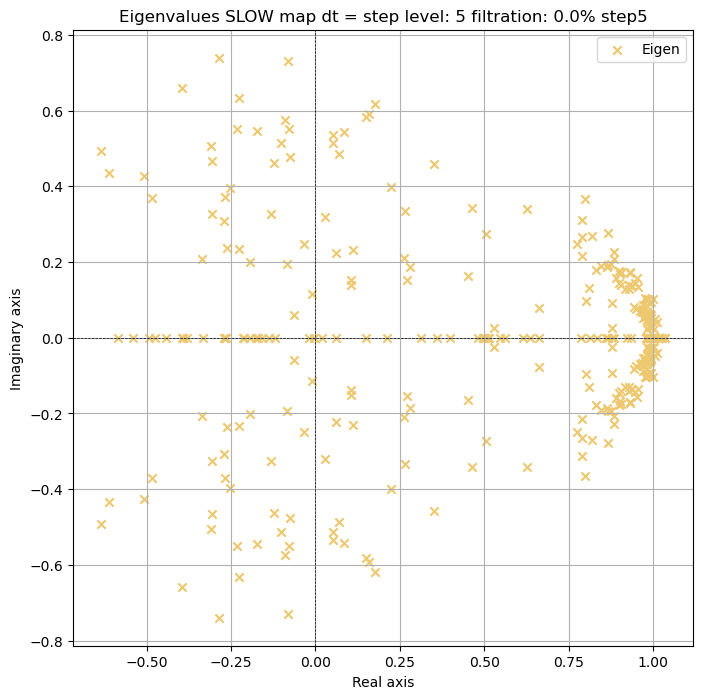

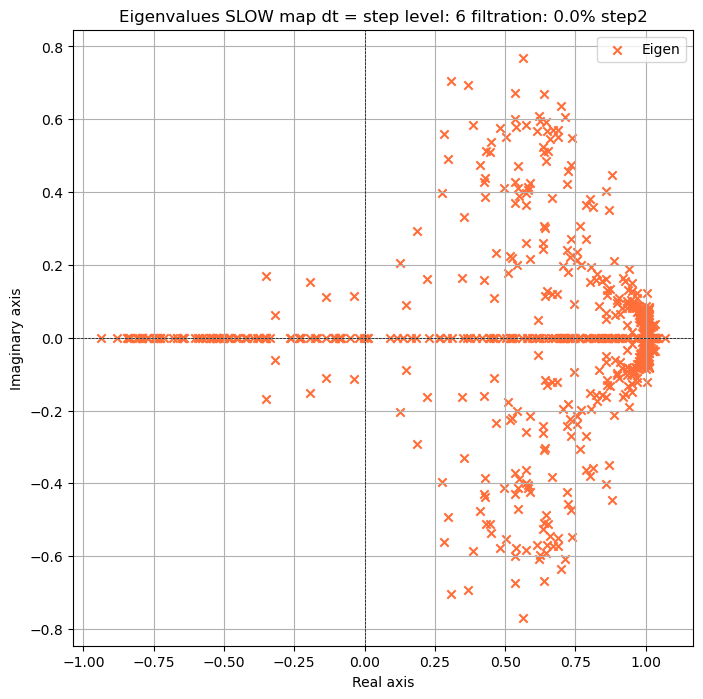

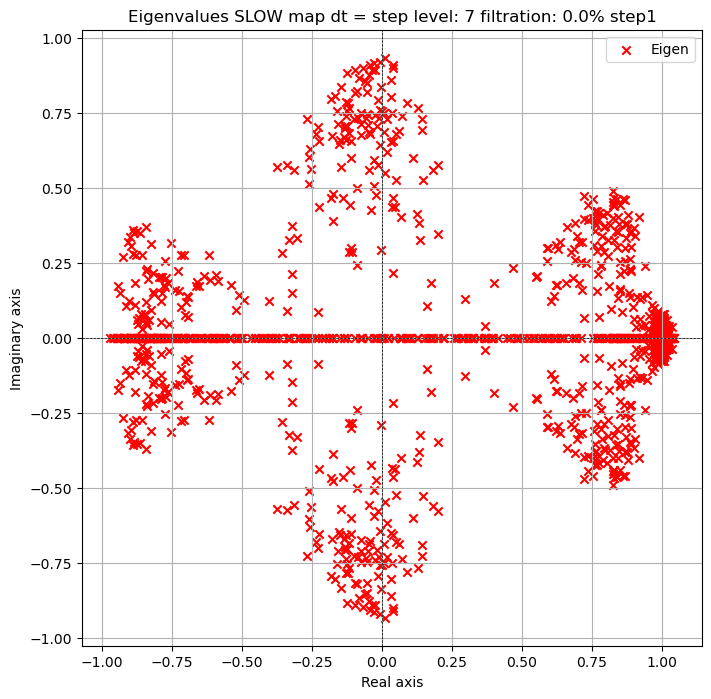

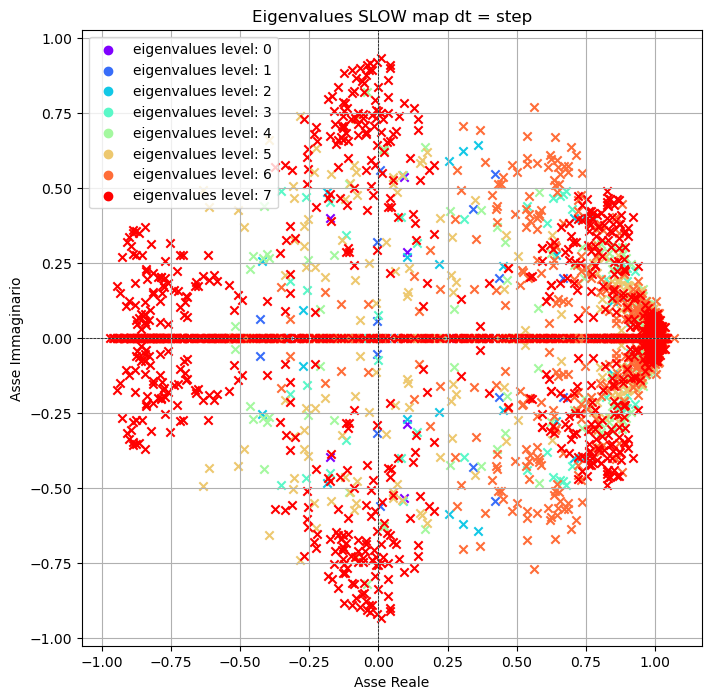

In [26]:

#plot of only eigenvalues SLOW with dt = step, each level in a single plot
colors = plt.cm.rainbow(np.linspace(0, 1, iteration_level(nodes) + 1))
for level in range (0, iteration_level(nodes) + 1):
    eigenvalues = []
    filtration = []
    for node in nodes:
        if node.level == level:
            eigenvalues.extend(node.mu_SLOW_step)
            filtration.extend([node.percentage_of_filtration])
            step = node.step

    real_part = np.real(eigenvalues)
    imag_part = np.imag(eigenvalues)

    percentage_of_filtration = sum(filtration) / len(filtration)

    plt.figure(figsize=(8, 8))
    plt.scatter(real_part, imag_part, marker='x', color=colors[level], label='Eigen')

    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.axvline(0, color='black', linewidth=0.5, linestyle='--')

    plt.title('Eigenvalues SLOW map dt = step level: ' + str(level) + ' filtration: ' + str(percentage_of_filtration) + '%' + ' step' + str(step))
    plt.xlabel('Real axis')
    plt.ylabel('Imaginary axis')
    plt.legend()

    plt.grid(True)
    plt.show()







#plot of all eigenvalues SLOW with dt = step of all levels in a single plot 
colors = plt.cm.rainbow(np.linspace(0, 1, iteration_level(nodes) + 1))

plt.figure(figsize=(8, 8))

for level in range(iteration_level(nodes) + 1):
    plt.scatter([],[], color = colors[level], label = "eigenvalues level: " + str(level))
    for node in nodes:
        if node.level == level:
            #plt.scatter(node.eigs.real / (2* pi * node.step), node.eigs.imag / (2 * pi * node.step), marker='x', color=colors[level])
            plt.scatter(node.mu_SLOW_step.real, node.mu_SLOW_step.imag, marker='x', color=colors[level])


plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')

plt.title('Eigenvalues SLOW map dt = step')
plt.xlabel('Asse Reale')
plt.ylabel('Asse Immaginario')
plt.legend()

plt.grid(True)
plt.show()




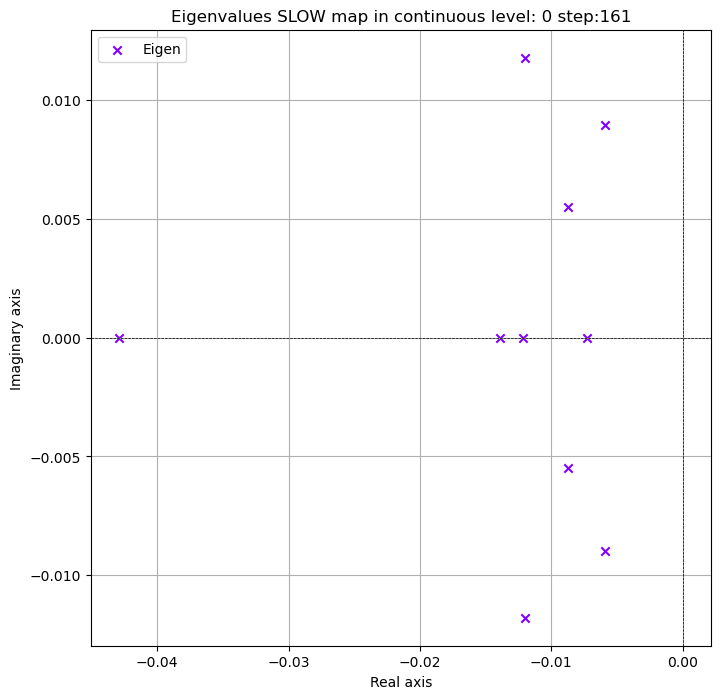

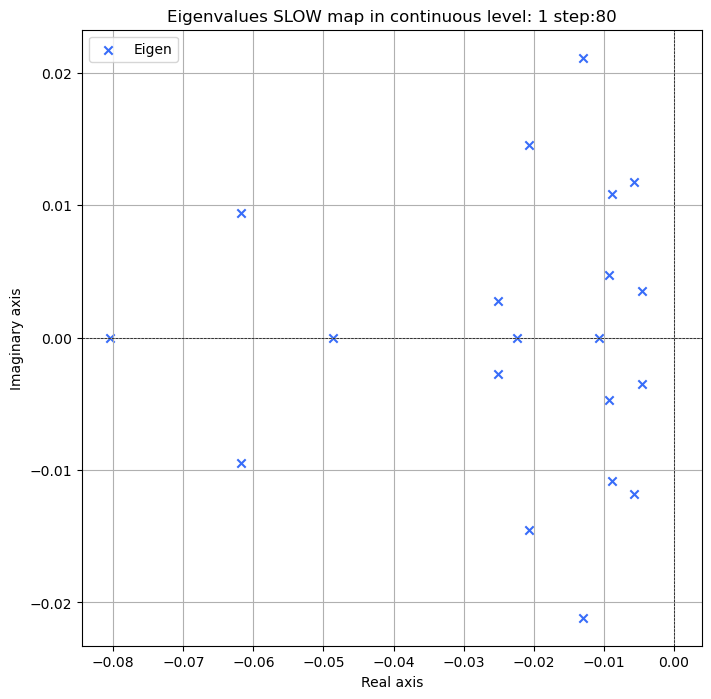

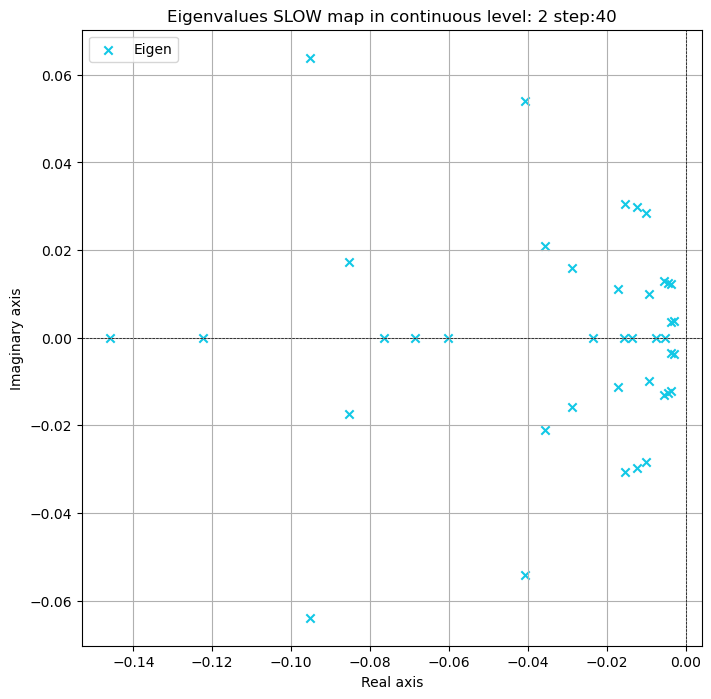

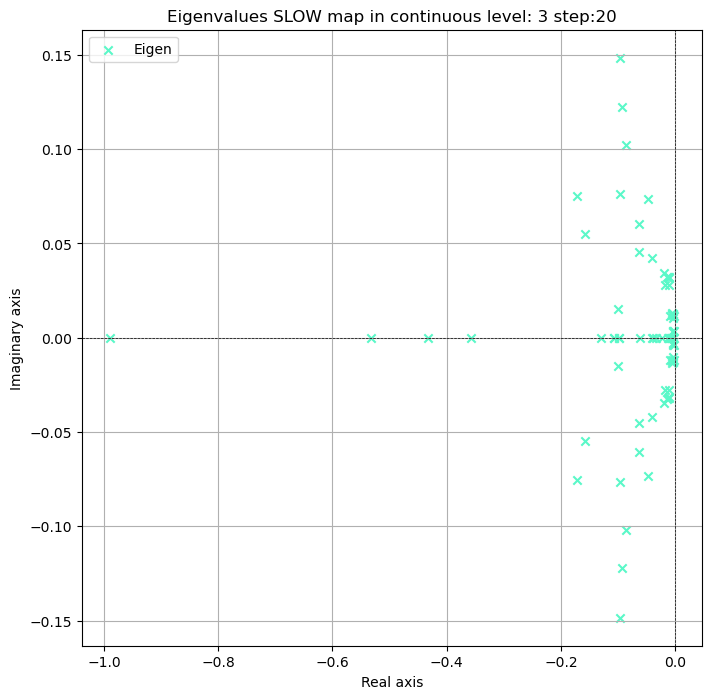

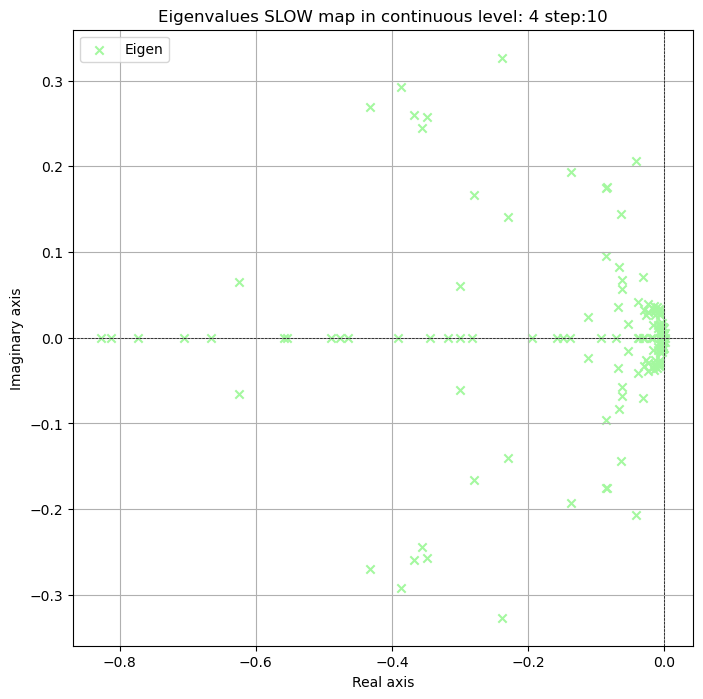

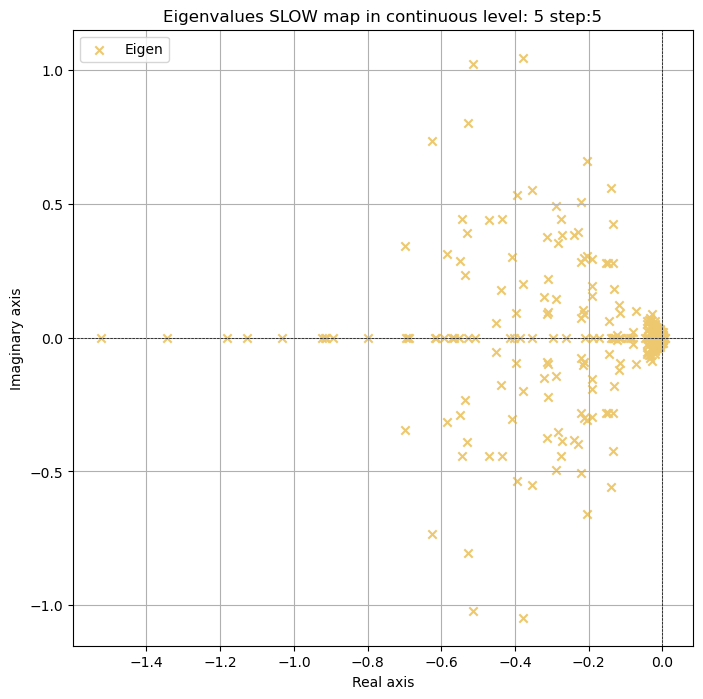

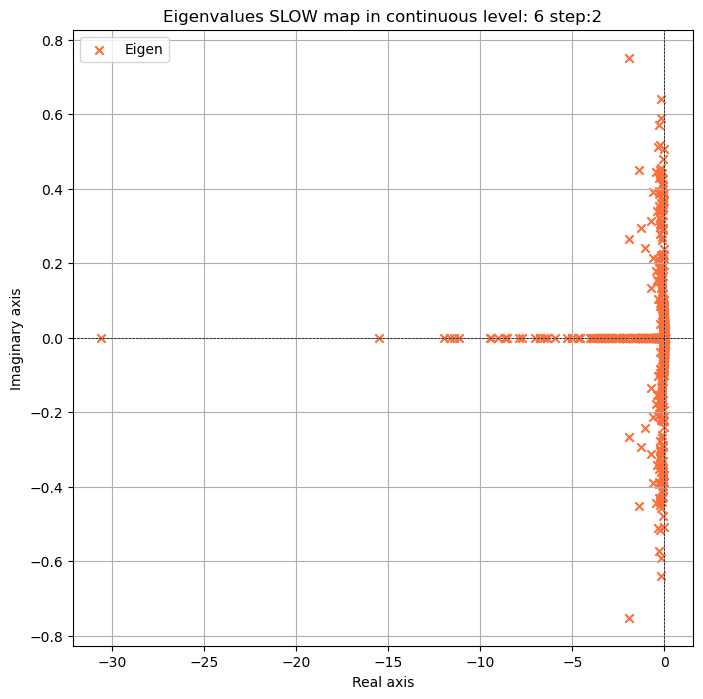

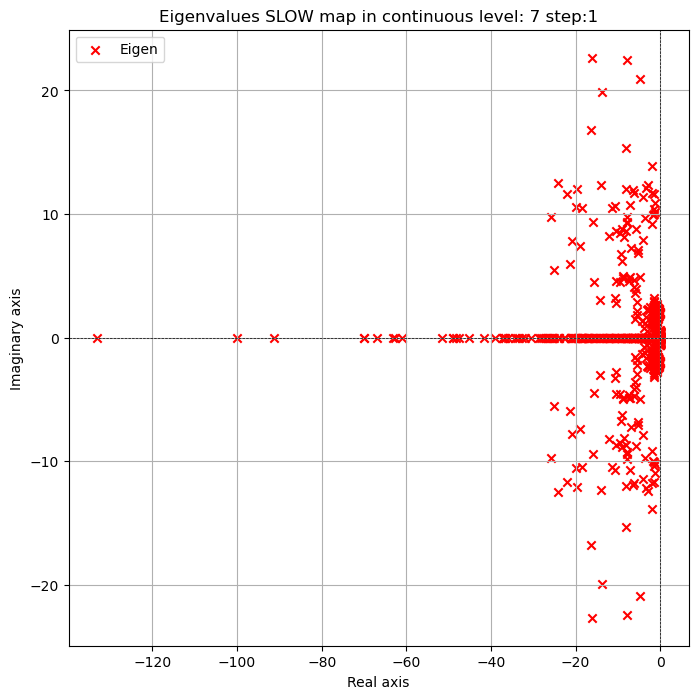

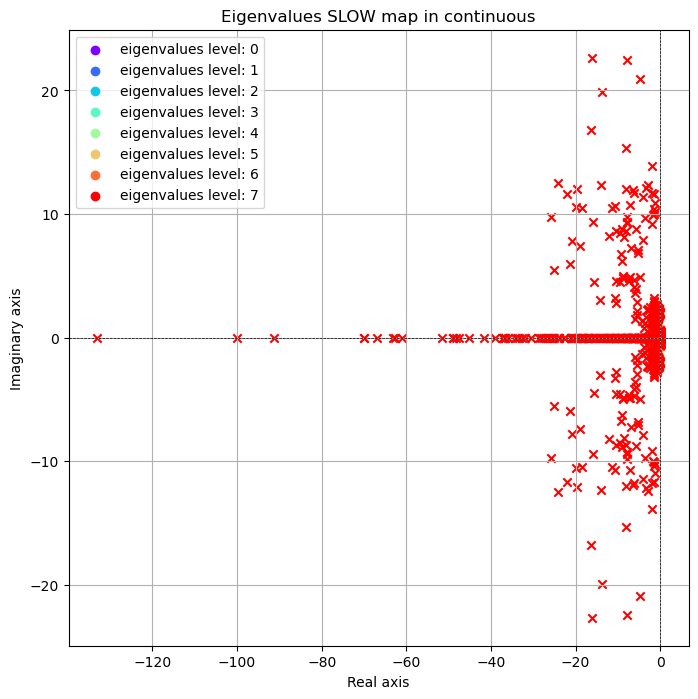

In [27]:
#plot of eigenvalues SLOW of each level in continuous
colors = plt.cm.rainbow(np.linspace(0, 1, iteration_level(nodes) + 1))
for level in range (0, iteration_level(nodes) + 1):
    eigenvalues = []
    #filtration = []
    for node in nodes:
        if node.level == level:
            step = node.step
            if node.mu_SLOW_cont is None:
                break
            eigenvalues.extend(node.mu_SLOW_cont)
            #filtration.extend([node.percentage_of_filtration])

    real_part = np.real(eigenvalues)
    imag_part = np.imag(eigenvalues)

    #if len(filtration) != 0:
    #   percentage_of_filtration = sum(filtration) / len(filtration)

    plt.figure(figsize=(8, 8))
    plt.scatter(real_part, imag_part, marker='x', color=colors[level], label='Eigen')

    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.axvline(0, color='black', linewidth=0.5, linestyle='--')

    plt.title('Eigenvalues SLOW map in continuous level: ' + str(level) + ' step:' +str(step))
    plt.xlabel('Real axis')
    plt.ylabel('Imaginary axis')
    plt.legend()

    plt.grid(True)
    plt.show()



    
#plot of all eigenvalues SLOW in continuous in the same plot 
colors = plt.cm.rainbow(np.linspace(0, 1, iteration_level(nodes) + 1))

plt.figure(figsize=(8, 8))

for level in range(iteration_level(nodes) + 1):
    plt.scatter([],[], color = colors[level], label = "eigenvalues level: " + str(level))
    for node in nodes:
        if node.level == level:
            if node.mu_SLOW_cont is None:
                break
            plt.scatter(node.mu_SLOW_cont.real, node.mu_SLOW_cont.imag, marker='x', color=colors[level])

plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')

plt.title('Eigenvalues SLOW map in continuous')
plt.xlabel('Real axis')
plt.ylabel('Imaginary axis')
plt.legend()

plt.grid(True)
plt.show()


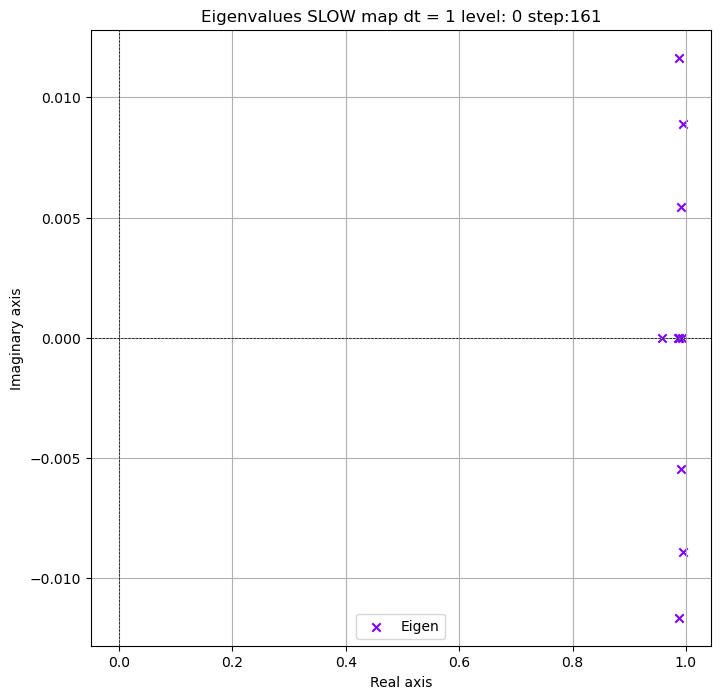

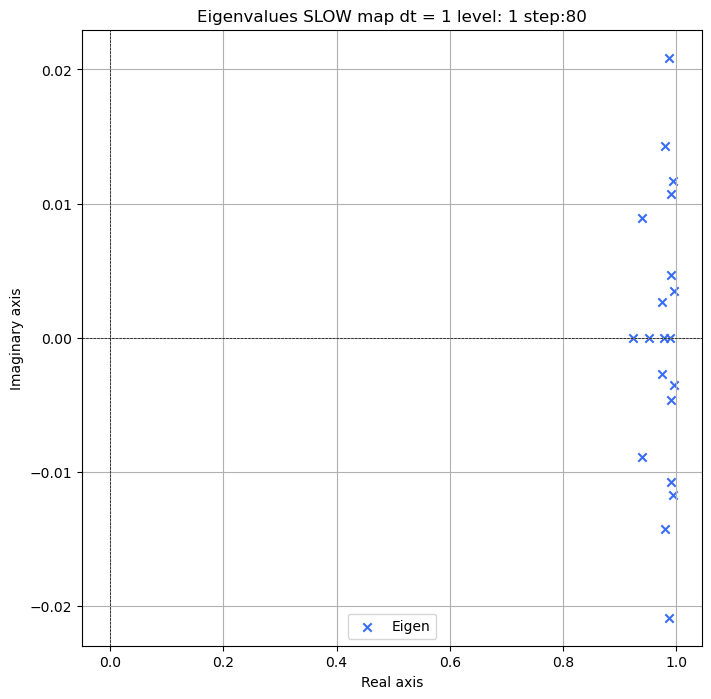

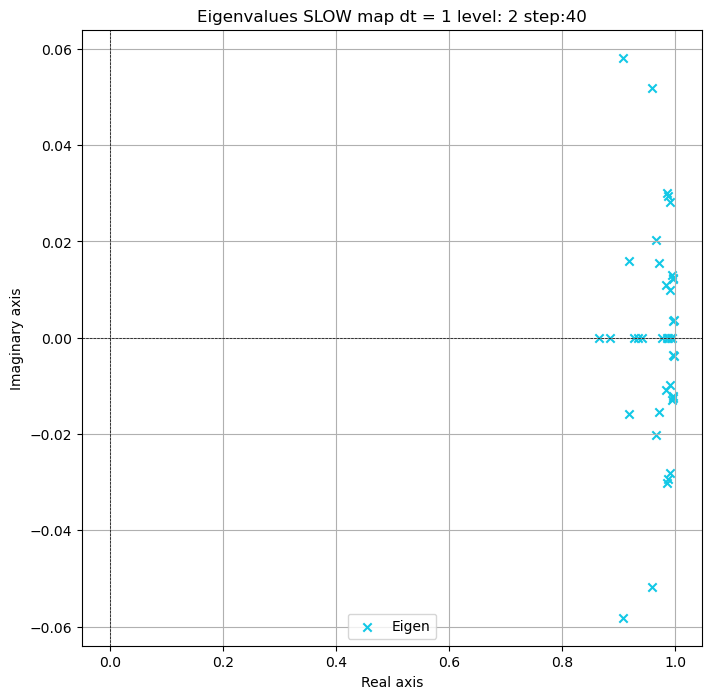

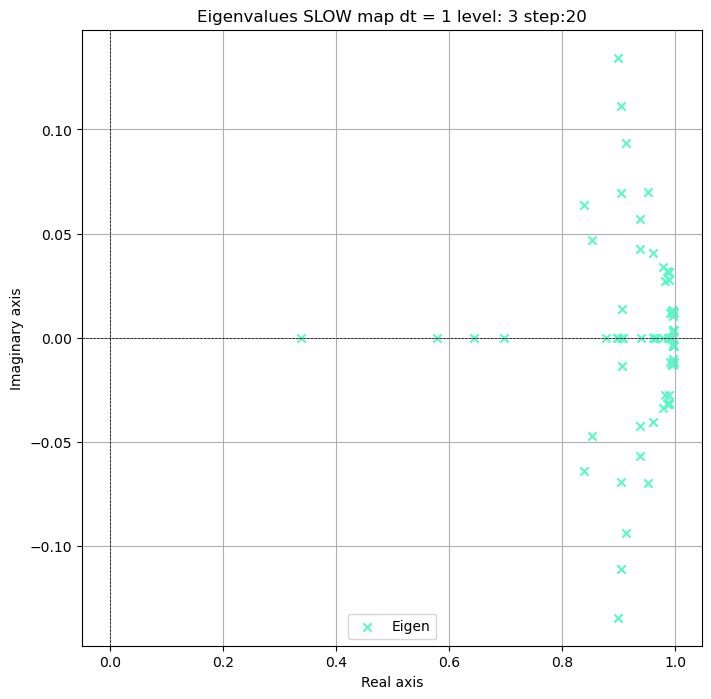

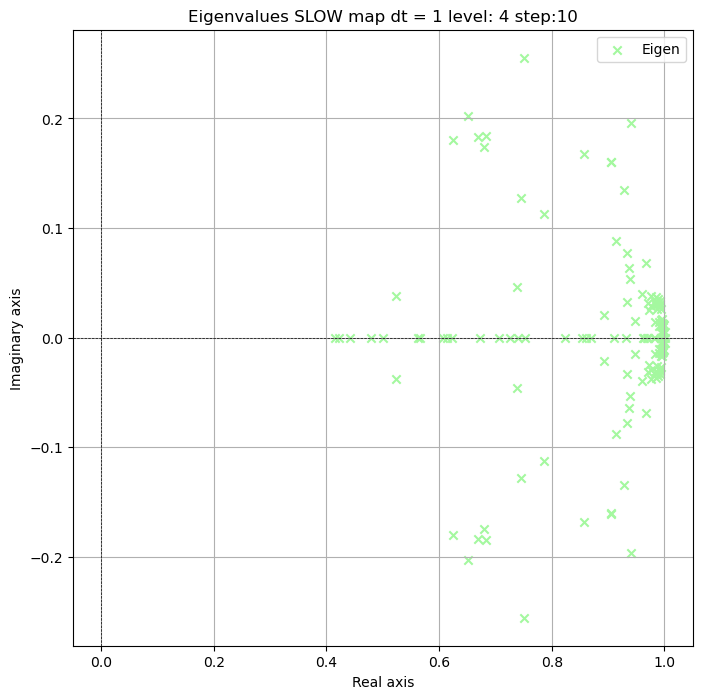

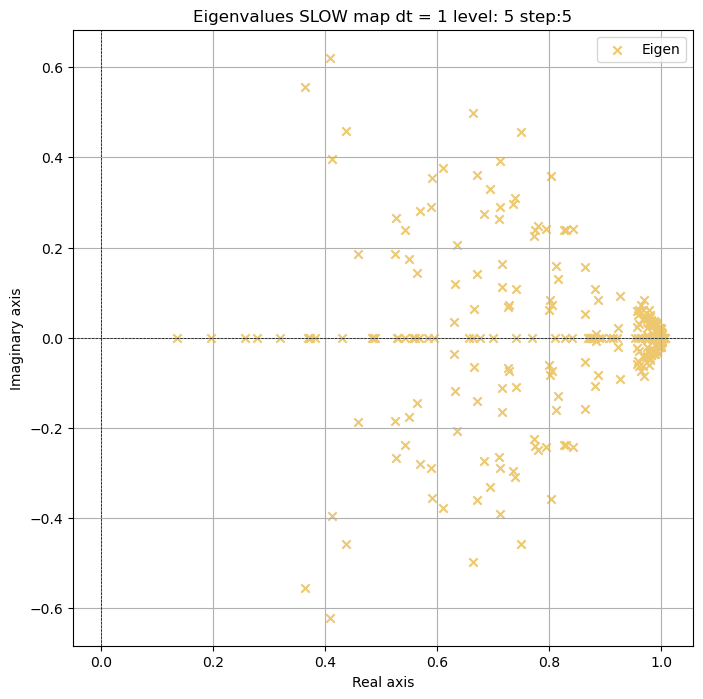

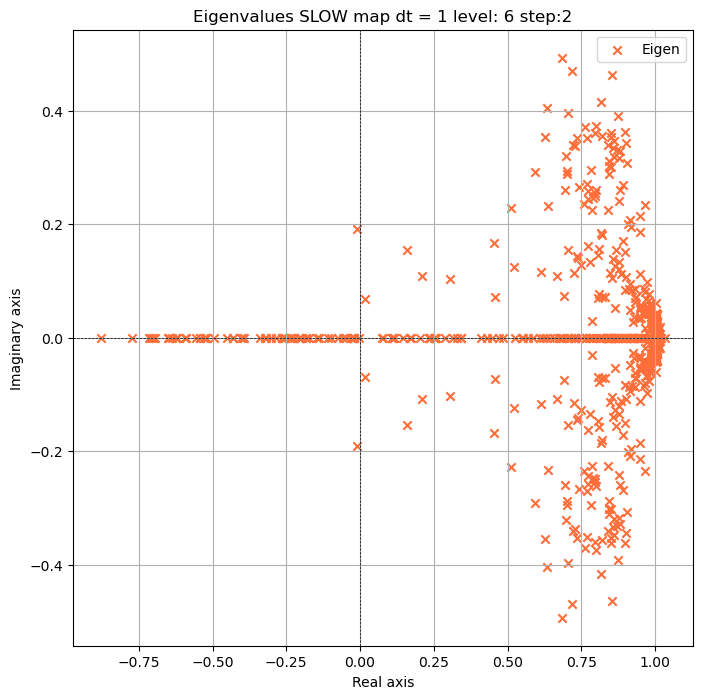

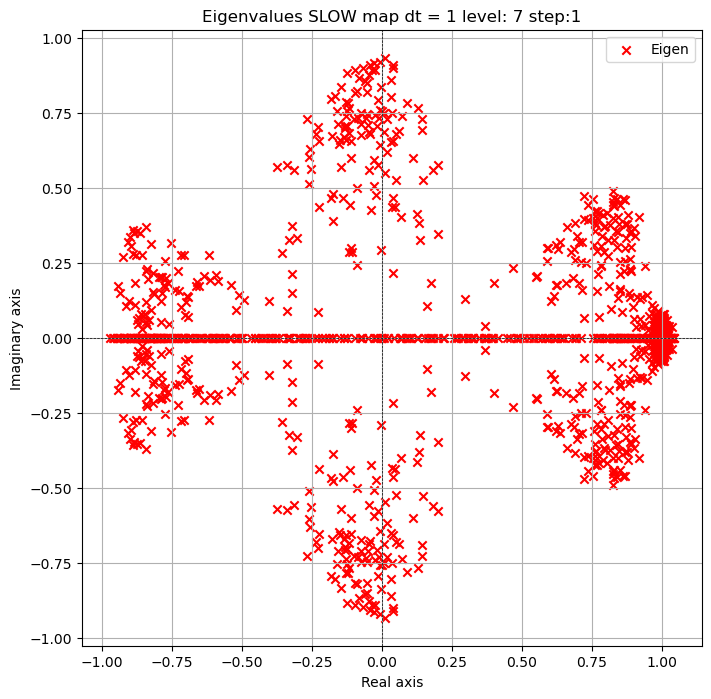

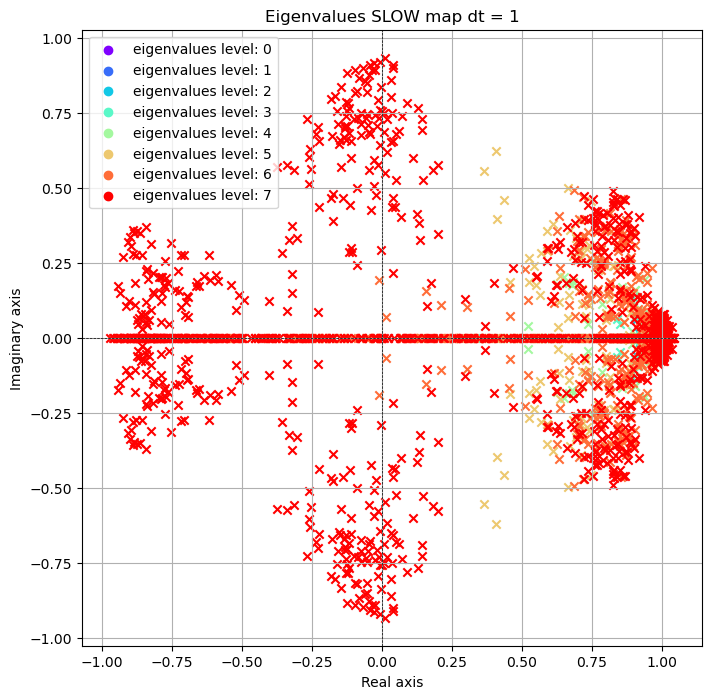

In [28]:

#plot of eigenvalues SLOW of each level with dt = 1
colors = plt.cm.rainbow(np.linspace(0, 1, iteration_level(nodes) + 1))

for level in range (0, iteration_level(nodes) + 1):
    eigenvalues = []
    #filtration = []
    for node in nodes:
        if node.level == level:
            step = node.step
            if node.mu_SLOW_cont is None:
                break
            eigenvalues.extend(node.mu_SLOW_1)
            #filtration.extend([node.percentage_of_filtration])

    real_part = np.real(eigenvalues)
    imag_part = np.imag(eigenvalues)

    #if len(filtration) != 0:
    #   percentage_of_filtration = sum(filtration) / len(filtration)

    plt.figure(figsize=(8, 8))
    plt.scatter(real_part, imag_part, marker='x', color=colors[level], label='Eigen')

    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.axvline(0, color='black', linewidth=0.5, linestyle='--')

    plt.title('Eigenvalues SLOW map dt = 1 level: ' + str(level) + ' step:' +str(step))
    plt.xlabel('Real axis')
    plt.ylabel('Imaginary axis')
    plt.legend()

    plt.grid(True)
    plt.show()




#plot of all eigenvalues SLOW with dt = 1 in the same plot 
colors = plt.cm.rainbow(np.linspace(0, 1, iteration_level(nodes) + 1))

plt.figure(figsize=(8, 8))

for level in range(iteration_level(nodes) + 1):
    plt.scatter([],[], color = colors[level], label = "eigenvalues level: " + str(level))
    for node in nodes:
        if node.level == level:
            if node.mu_SLOW_cont is None:
                break
            plt.scatter(node.mu_SLOW_1.real, node.mu_SLOW_1.imag, marker='x', color=colors[level])

plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')

plt.title('Eigenvalues SLOW map dt = 1')
plt.xlabel('Real axis')
plt.ylabel('Imaginary axis')
plt.legend()

plt.grid(True)
plt.show()
